In [55]:
import math
import numpy as np
import codecs, json 
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
import pandas as pd

%matplotlib inline

In [2]:
c_error = np.array([[ 0.53,  0.17,  0.27,  0.27,  0.33,  0.33,  0.31,  0.28],
       [ 0.19, -0.05,  0.02,  0.05,  0.11,  0.06,  0.03, -0.01],
       [ 0.21, -0.  ,  0.13,  0.08,  0.14,  0.14,  0.04, -0.05],
       [ 0.27, -0.05,  0.09,  0.04,  0.15,  0.19,  0.05, -0.05],
       [ 0.22, -0.24, -0.14, -0.  ,  0.08,  0.16,  0.03, -0.05],
       [ 0.01, -0.4 , -0.28, -0.1 , -0.05,  0.07,  0.03, -0.05],
       [-0.23, -0.42, -0.3 , -0.22, -0.13,  0.01,  0.03, -0.08],
       [-0.21, -0.46, -0.28, -0.24, -0.17,  0.01, -0.08, -0.13]])

c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
#     arr = arr - c_error
    arr = np.amax(arr, axis = 0) - c_maxnoise
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [89]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet')
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None, mintemp = 26, maxtemp = 32):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))

In [4]:
lbicubic = []
def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)
    
    weight = np.ones(diff.shape)
    for i in range(diff.shape[0]):
        n = 0
        n_skew = 10000
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.
        lbicubic.append(bicubic)
        sort_diff = np.unique(bicubic)
        mode =  0
        start = 0
        for j in range(int(sort_diff.shape[0]/2)):
            num = bicubic[bicubic == sort_diff[j]].shape[0]
            if (num > mode):
                mode = num
                start = j
        for j in range(max(2,start),int(sort_diff.shape[0]/2)):
            t_skew = abs(st.skew(bicubic[bicubic < sort_diff[j]] ))
            if t_skew < n_skew:
                n_skew = t_skew
                n = sort_diff[j]
        weight[i,diff[i] >= n] = 0 
    
    return weight.reshape(-1,8,8)

def get_weight2(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)

#     weight = np.ones(diff.shape[0])
    weight = np.ones(diff.shape)
    for i in range(diff.shape[0]):
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.

        gmm = GaussianMixture(n_components = 2)
        gmm = gmm.fit(X=bicubic.reshape(-1,1))
        gmm_x = np.linspace(np.amin(bicubic),np.amax(bicubic),100)
        gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
        gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
        gmm_d = np.exp(gmm.score_samples(diff[i].reshape(-1,1)))
        gmm_d2 = gmm.predict_proba(diff[i].reshape(-1,1))
        if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
            gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
            gmm_d2[:,[0,1]] = gmm_d2[:,[1,0]]
#         weight[i] = gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)]
        weight[i] = gmm_d2[:,0]*gmm_d
        
    return weight.reshape(-1,8,8)

In [86]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol.reshape(-1,8,8)

# def output_interpolate(temp_path, ln2):
#     bgpath = 'train/' + temp_path + '/output-empty/1.txt'
#     interpol = np.zeros((4,ln2**2,8,8))
#     ln = 6
#     bg_max = 0
#     for i in range(4):
#         datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

#         garr = read_gtempdata(100,datapath,ln**2)
#         arrbg = read_tempdata(100,bgpath)

#         weight = get_weight(garr,arrbg)

#         bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
#         bg_max += np.mean(bg_mean)

#         garr2 = (garr.transpose(1,2,0) -bg_mean).transpose(2,0,1)
#         interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
#         ln -= 1
#     bg_max /= 4
#     return interpol+bg_max
shifty = []
shifty.append( np.ones((4,36)))
shifty.append( np.ones((4,25)))
shifty.append( np.ones((4,16)))
shifty.append( np.ones((4,9)))
def output_interpolate(temp_path, ln2, j):
    bgpath = 'train/' + temp_path + '/output-empty/1.txt'
    interpol = np.zeros((4,ln2**2,8,8))
    ln = 6
    bg_max = 0
    bg_min = 100000
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)
        arrbg = read_tempdata(100,bgpath)
        show_temp(arrbg)
        weight = get_weight2(garr,arrbg)

        bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
        
#         bg_max += np.mean(bg_mean)
        bg_max = max(bg_max,np.amax(bg_mean))
        bg_min = min(bg_min,np.amin(bg_mean))
#         bg_mean = get_weight2(garr,arrbg)
        garr2 = (garr.transpose(1,2,0) -bg_mean).transpose(2,0,1)
        interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
        shifty[i][j] = bg_mean
        ln -= 1
#     bg_max /= 4
    print(bg_max)
    print(bg_max-bg_min)
    for i in range(4):
        shifty[i][j] = bg_max-shifty[i][j]
    return interpol+bg_max

def full_interpolate():
    ln = 6
    interpol = np.zeros((4,4,ln**2,8,8))
#     super_interpol = np.zeros((4,ln**3,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        interpol[i] = output_interpolate(temp_path[i],ln, i)
#         super_interpol[i] = thermal_interpolate(interpol[i],4,ln**2,ln,ln**2)
#     full_interpol = thermal_interpolate(super_interpol,3,ln**3,ln,ln**3).reshape(ln,ln,ln**2,8,8)
    
    amax = np.zeros((4,4,ln,ln))
    for amb in range(4):
        for layer in range(4):
            for n in range(ln**2):
                col = int(n/ln)
                row = int(n%ln)
                bicubic = griddata(points, interpol[amb,layer,n].reshape(-1), (grid_x, grid_y), method='cubic')
                amax[amb,layer,col,row] = np.amax(bicubic)
                
    return interpol, amax

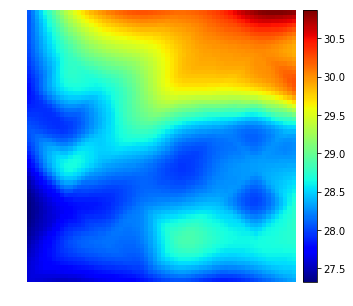

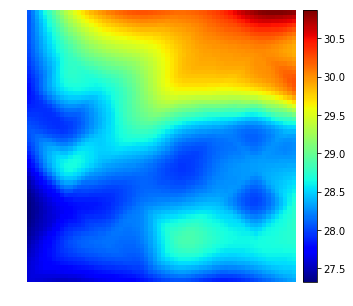

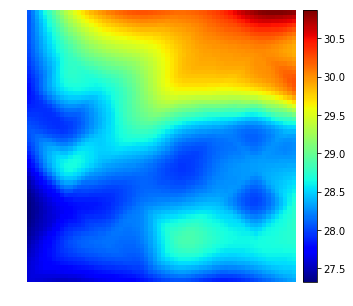

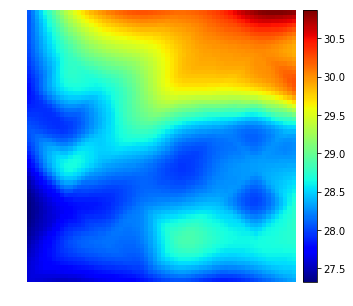

30.144493323714006
2.0533425365912663


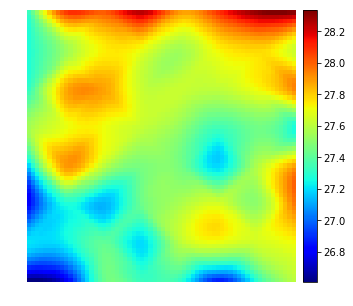

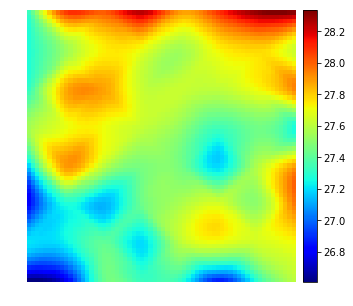

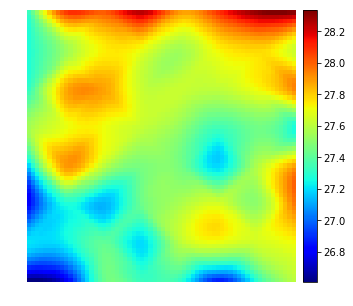

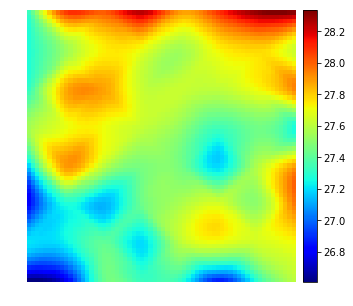

28.117090641951425
1.8216599874042636


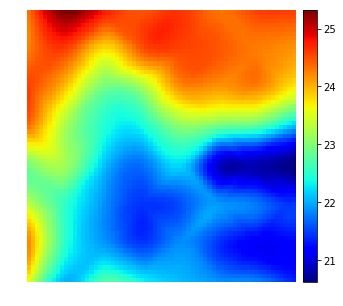

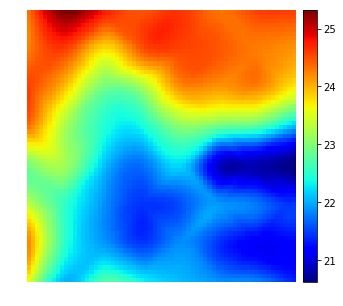

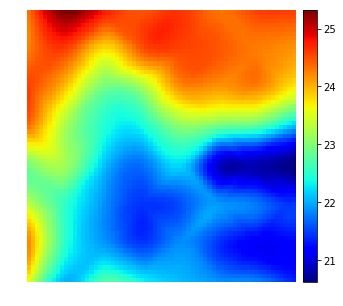

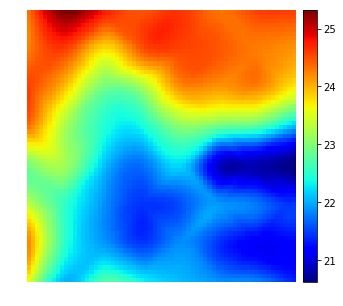

25.753330476546328
4.386162217943017


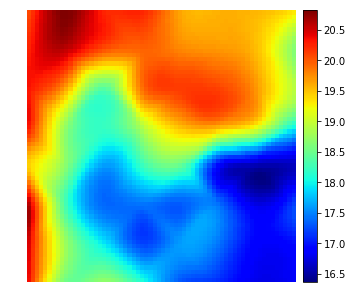

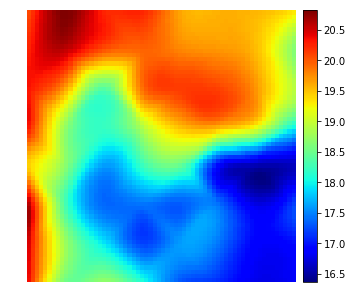

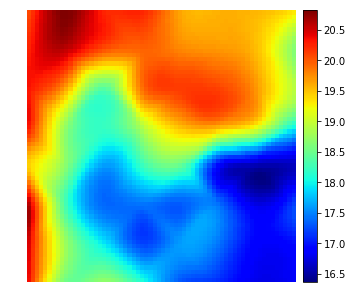

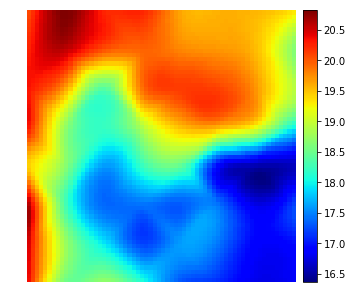

22.527912415312997
3.429636402098925


In [90]:
lbicubic = []
interpol, amax = full_interpolate()
mean = np.mean(amax)

In [32]:
shifty

[array([[1.5401789 , 1.14915571, 1.39863006, 1.40626537, 1.43244168,
         1.34665619, 1.47660418, 1.44792924, 1.43520638, 1.55976781,
         1.77665375, 1.75543831, 1.44783456, 0.54672479, 0.31730576,
         1.39565903, 1.49610514, 2.08642034, 1.74069411, 0.90007978,
         1.35613053, 1.35898949, 1.37070956, 1.51571641, 0.64718876,
         1.406345  , 1.84463966, 1.09380192, 1.61056001, 1.45836094,
         1.63834601, 1.08791848, 1.38228742, 1.82180738, 1.25939261,
         1.56173948],
        [1.46793614, 0.99002879, 1.0171715 , 1.14275555, 1.13581541,
         1.0191059 , 1.00211935, 1.40417838, 1.40160026, 1.52803695,
         1.28026547, 1.17154304, 0.71161253, 0.93699487, 0.86160219,
         1.04039736, 0.54686821, 0.42999762, 0.97775491, 1.3418134 ,
         1.59753787, 1.82165999, 1.07331726, 1.31724173, 1.30089759,
         1.02177826, 1.29258818, 1.46295943, 1.53029846, 1.08499962,
         1.32115154, 1.13387277, 1.23434074, 1.34705519, 1.49909265,
         1.3

[0.66115161 1.63722402 4.38616222]
[0.53319782 1.58370776 3.43817339]
[0.43936059 1.32597591 3.3729765 ]
[0.26736091 0.92122527 1.95294385]


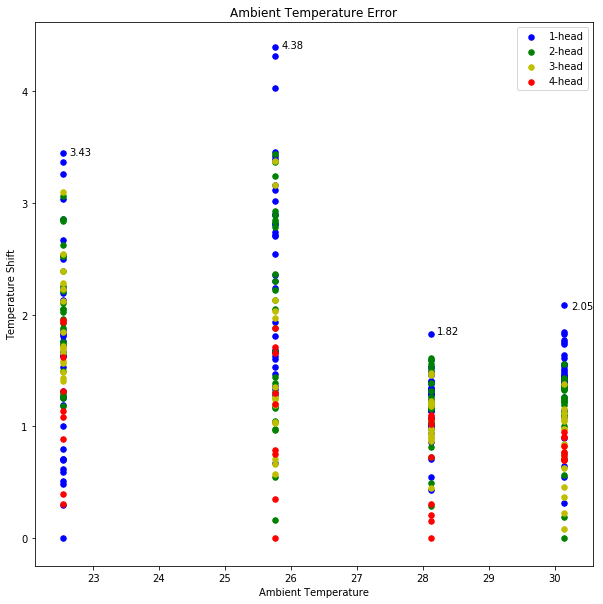

In [71]:
x=[30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674]
y=[2.0520057885509253,1.8216599874042636,4.384944194607751,3.4291026310700303]
jj = [36,25,16,9]
ppd2 = np.ones((4,3))
lbl = ['1-head', '2-head','3-head','4-head']
col = ['b','g','y','r']
plt.figure(figsize=(10, 10))
for j in range(4):
    xx = (np.ones((jj[j],4))*x).transpose(1,0)
    plt.scatter(xx, shifty[j], label = lbl[j], color = col[j], s = 30)
    ppd2[j] = [np.var(shifty[j]),np.mean(shifty[j]),np.amax(shifty[j])]
    print(ppd2[j])
for i,j in zip(x,y):
    plt.annotate(str(round(j,2)),xy=(i+0.1,j))
plt.xlabel("Ambient Temperature")
plt.ylabel("Temperature Shift")
plt.title("Ambient Temperature Error")
plt.legend()
plt.show()

In [56]:
shsh = np.ones((4,36+25+16+9))
ppd = np.ones((4,3))
for i in range(4):
    shsh[i] = np.concatenate((shifty[0][i],shifty[1][i],shifty[2][i],shifty[3][i]))
    ppd[i] = [np.var(shsh[i]),np.mean(shsh[i]),np.amax(shsh[i])]
    print(ppd[i])

[0.17598187 1.14167193 2.08642034]
[0.12117324 1.09839533 1.82165999]
[0.94345425 1.9503898  4.38616222]
[0.56506721 1.76486389 3.44113737]


In [83]:
coln = ['1-Head', '2-Head','3-Head','4-Head']
row = ['Variance', 'Mean', 'Max']
df = pd.DataFrame(np.array(ppd).round(2),np.array(x).round(2),row)
print(df.to_latex( bold_rows = True))

\begin{tabular}{lrrr}
\toprule
{} &  Variance &  Mean &   Max \\
\midrule
\textbf{30.14} &      0.18 &  1.14 &  2.09 \\
\textbf{28.12} &      0.12 &  1.10 &  1.82 \\
\textbf{25.75} &      0.94 &  1.95 &  4.39 \\
\textbf{22.54} &      0.57 &  1.76 &  3.44 \\
\bottomrule
\end{tabular}



In [85]:
coln = ['1-Head', '2-Head','3-Head','4-Head']
row = ['Variance', 'Mean', 'Max']
df = pd.DataFrame(np.array(ppd2).round(2),coln,row)
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Variance &  Mean &   Max \\
\midrule
1-Head &      0.66 &  1.64 &  4.39 \\
2-Head &      0.53 &  1.58 &  3.44 \\
3-Head &      0.44 &  1.33 &  3.37 \\
4-Head &      0.27 &  0.92 &  1.95 \\
\bottomrule
\end{tabular}



In [39]:
lbicubic = []
interpol, amax = full_interpolate()
mean = np.mean(amax)

30.143156575673665
28.09115078712274
28.117090641951425
26.29543065454716
25.752112453211062
21.36716825860331
22.527912415312997
19.098809784242967


In [91]:
amb_dis2 = np.array([[ 4.6 ,  4.63,  4.7 ,  4.55],
       [ 6.05,  6.1 ,  5.64,  5.23],
       [ 8.33,  8.34,  6.97,  6.2 ],
       [10.02,  9.26,  8.69,  8.49]])
coln = ['1-Head', '2-Head','3-Head','4-Head']
row = ['Variance', 'Mean', 'Max']
df = pd.DataFrame(np.array(amb_dis2).round(2),np.array(x).round(2),coln)
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  1-Head &  2-Head &  3-Head &  4-Head \\
\midrule
30.14 &    4.60 &    4.63 &    4.70 &    4.55 \\
28.12 &    6.05 &    6.10 &    5.64 &    5.23 \\
25.75 &    8.33 &    8.34 &    6.97 &    6.20 \\
22.54 &   10.02 &    9.26 &    8.69 &    8.49 \\
\bottomrule
\end{tabular}



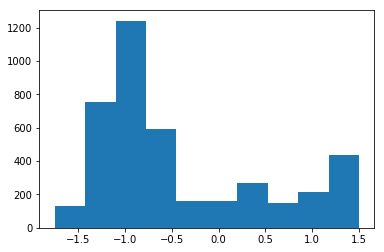

In [95]:
plt.hist(lbicubic[155], bins=10)
plt.show()

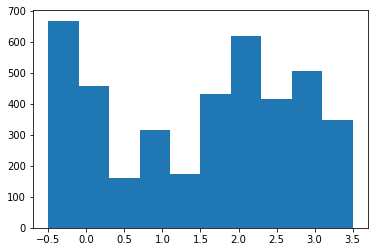

In [115]:
plt.hist(lbicubic[165], bins=10)
plt.show()

[-1.0, 0.5]


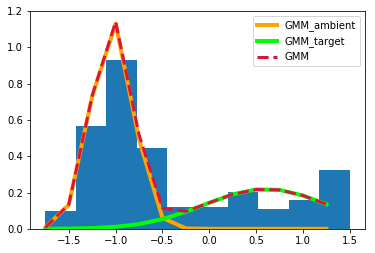

[-0.75, 0.75]


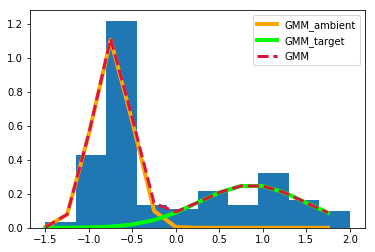

[-0.5, 0.75]


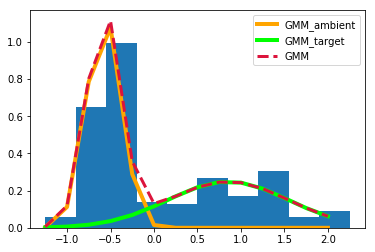

[-1.0, 0.5]


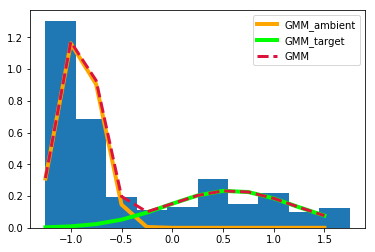

[-0.5, 1.0]


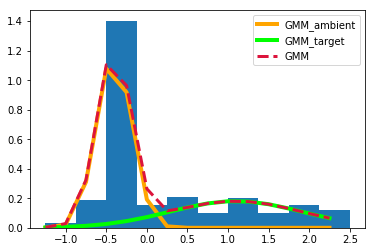

[-0.75, 0.75]


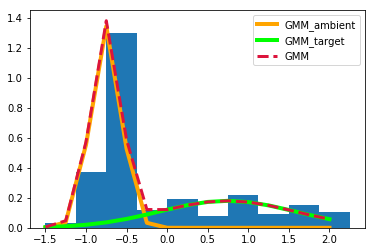

[-0.5, 1.25]


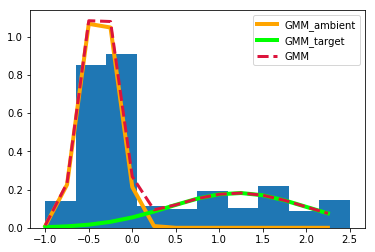

[0.0, 1.75]


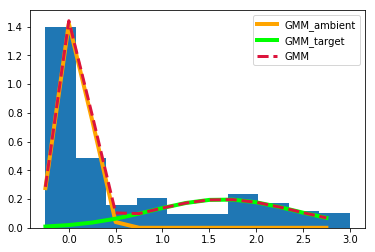

[0.25, 2.25]


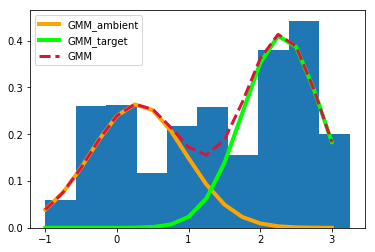

[0.5, 2.75]


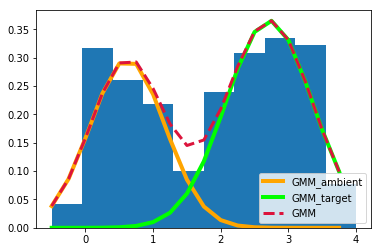

[-0.25, 2.0]


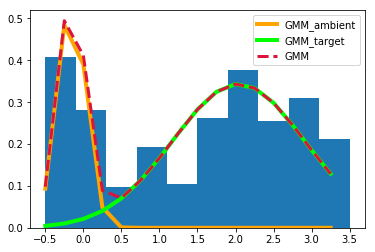

In [183]:
# i = 165
for i in range(155,166):
    gmm = GaussianMixture(n_components = 2)
    gmm = gmm.fit(X=lbicubic[i].reshape(-1,1))
#     gmm_x = np.linspace(np.amin(lbicubic[i]),np.amax(lbicubic[i]),10)
    gmm_x = np.arange(np.amin(lbicubic[i]),np.amax(lbicubic[i]),0.25)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
    gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
    if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
        gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
    print([gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)],gmm_x[np.argmax(gmm_y2[:,1]*gmm_y)]])
    fig, ax = plt.subplots()
    ax.hist(lbicubic[i], bins=10, density=True)
    ax.plot(gmm_x, gmm_y2[:,0]*gmm_y, color="orange", lw=4, label="GMM_ambient")
    ax.plot(gmm_x, gmm_y2[:,1]*gmm_y, color="lime", lw=4, label="GMM_target")
    ax.plot(gmm_x, gmm_y, color="crimson", lw=3, label="GMM", ls = "--")
#     ax.plot(gmm_x, gmm_y2[1]*gmm_y.reshape(-1,1), color="green", lw=4, label="GMM_grouping")

    plt.legend()

    plt.show()

[-1.0277777777777777, 0.6136363636363638]


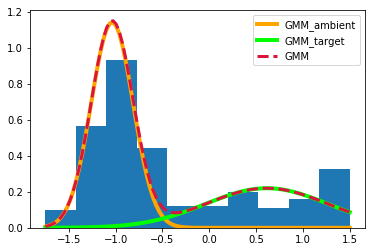

[-0.7222222222222222, 0.8686868686868685]


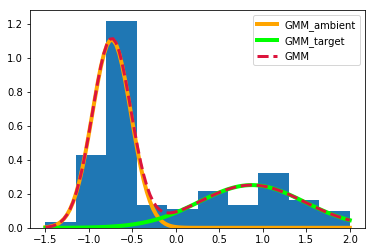

[-0.5782828282828283, 0.8358585858585856]


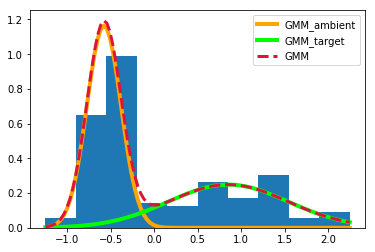

[-0.9166666666666666, 0.5681818181818183]


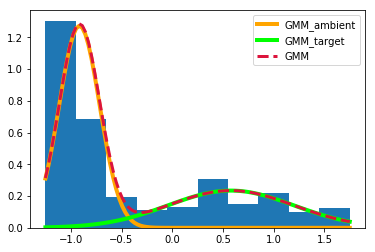

[-0.41666666666666663, 1.0984848484848486]


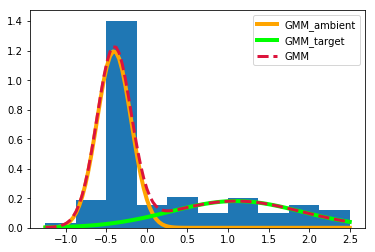

[-0.7424242424242424, 0.7348484848484849]


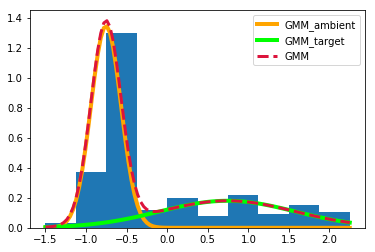

[-0.36363636363636365, 1.227272727272727]


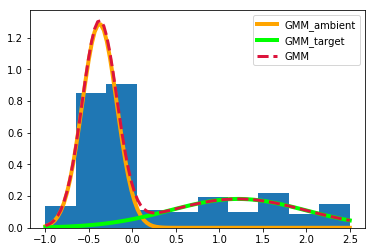

[0.04545454545454547, 1.6540404040404042]


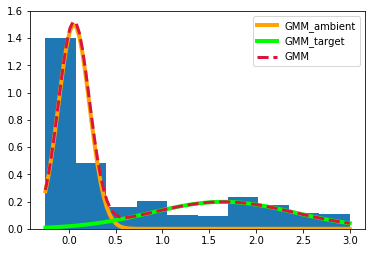

[0.15909090909090917, 2.2196969696969697]


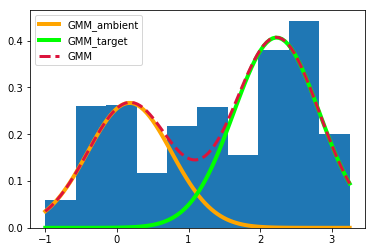

[0.7272727272727273, 2.8181818181818183]


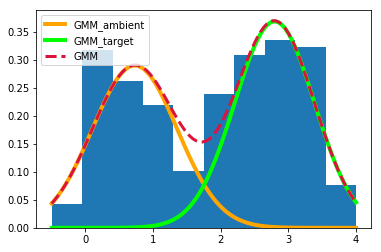

[-0.13636363636363635, 2.045454545454546]


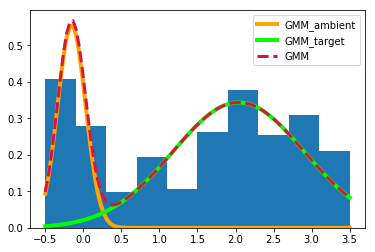

In [185]:
# i = 165
for i in range(155,166):
    gmm = GaussianMixture(n_components = 2)
    gmm = gmm.fit(X=lbicubic[i].reshape(-1,1))
    gmm_x = np.linspace(np.amin(lbicubic[i]),np.amax(lbicubic[i]),100)
#     gmm_x = np.arange(np.amin(lbicubic[i]),np.amax(lbicubic[i]),0.25)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
    gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
    if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
        gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
    print([gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)],gmm_x[np.argmax(gmm_y2[:,1]*gmm_y)]])
    fig, ax = plt.subplots()
    ax.hist(lbicubic[i], bins=10, density=True)
    ax.plot(gmm_x, gmm_y2[:,0]*gmm_y, color="orange", lw=4, label="GMM_ambient")
    ax.plot(gmm_x, gmm_y2[:,1]*gmm_y, color="lime", lw=4, label="GMM_target")
    ax.plot(gmm_x, gmm_y, color="crimson", lw=3, label="GMM", ls = "--")
#     ax.plot(gmm_x, gmm_y2[1]*gmm_y.reshape(-1,1), color="green", lw=4, label="GMM_grouping")

    plt.legend()

    plt.show()

[-0.5277777777777777, 0.8838383838383841]


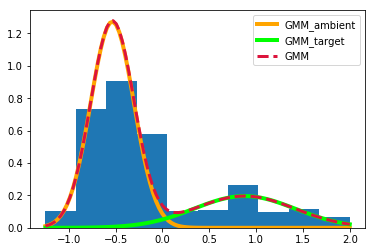

[-0.7651515151515151, 0.6590909090909092]


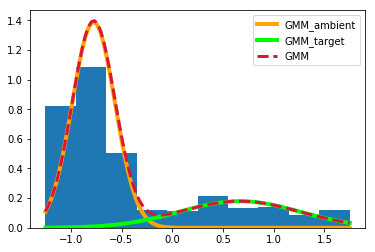

[-0.803030303030303, 0.4696969696969697]


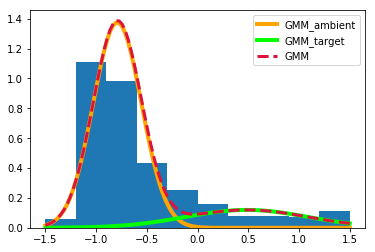

[-0.5227272727272727, 0.9015151515151514]


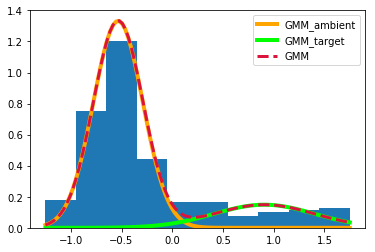

[-0.7954545454545455, 0.26515151515151514]


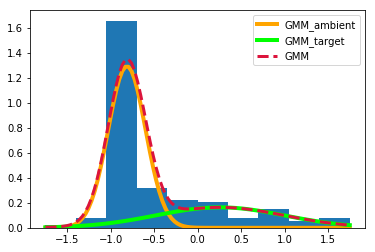

[-0.888888888888889, 0.5]


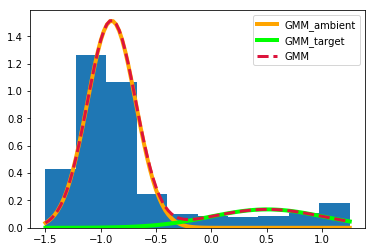

[-0.9924242424242424, 0.34090909090909083]


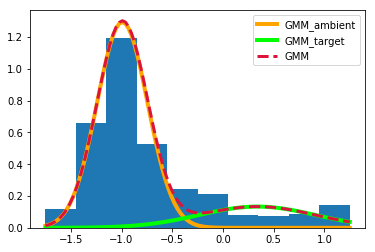

[-0.4949494949494949, 0.8181818181818181]


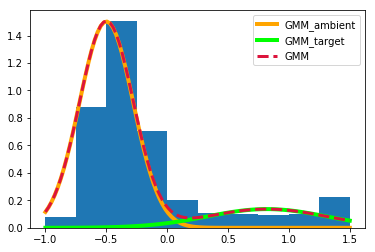

[-0.8308080808080807, 0.28535353535353547]


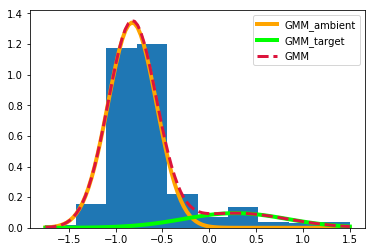

[-0.6111111111111112, 0.36111111111111094]


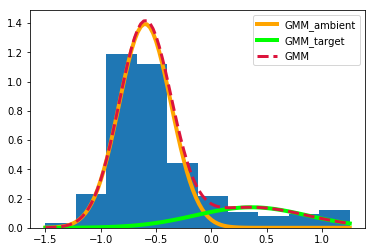

[-0.6792929292929292, 0.5353535353535355]


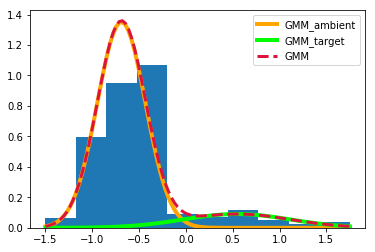

[-0.7727272727272727, 0.6515151515151514]


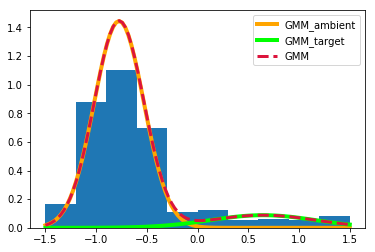

[-0.9444444444444445, 0.2777777777777777]


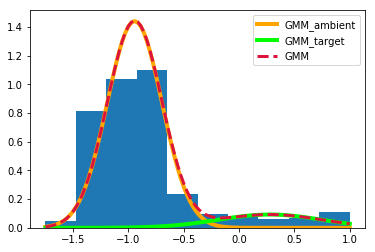

[-0.8333333333333334, 0.2222222222222221]


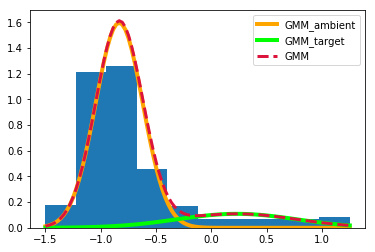

[-0.9242424242424242, 0.5303030303030303]


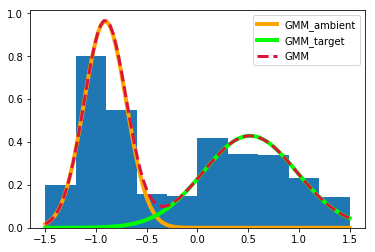

[-0.7121212121212122, 0.5303030303030303]


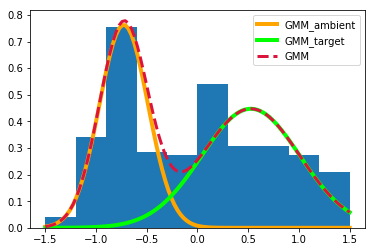

[-0.4722222222222222, 0.7651515151515151]


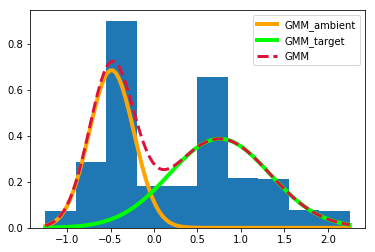

[0.23484848484848486, 1.4090909090909092]


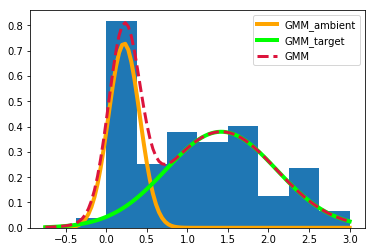

[-0.696969696969697, 0.48484848484848486]


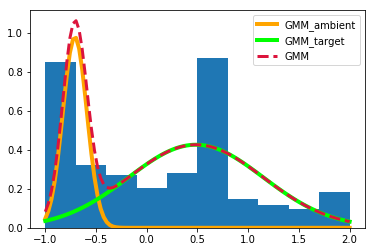

[-1.0277777777777777, 0.16666666666666652]


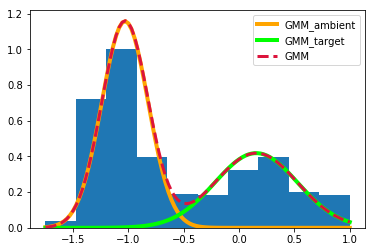

[-0.75, 0.43181818181818166]


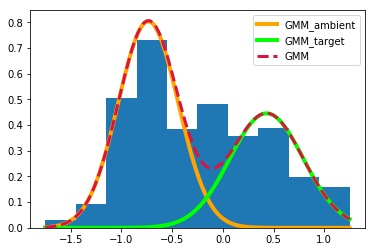

[-0.6893939393939394, 0.3005050505050506]


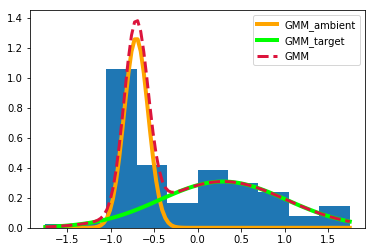

[-0.5151515151515151, 0.6060606060606062]


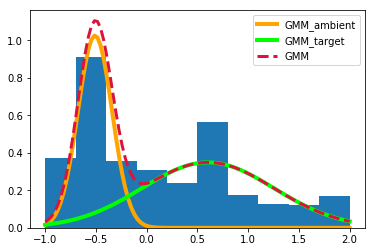

[-0.5454545454545454, 0.6666666666666667]


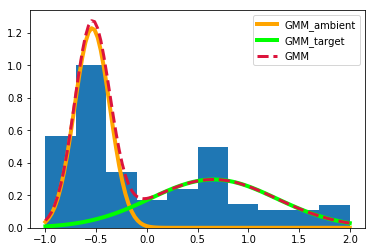

[-1.0833333333333335, 0.2777777777777777]


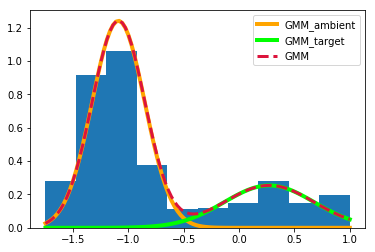

[-0.765151515151515, 0.5808080808080809]


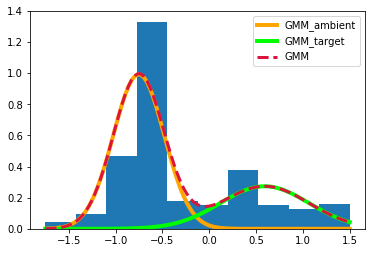

[-0.7777777777777777, 0.5353535353535355]


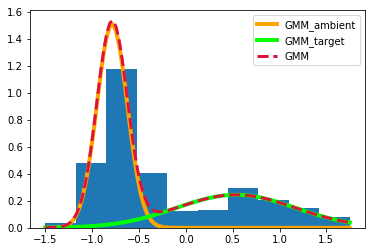

[-0.7045454545454546, 0.5984848484848486]


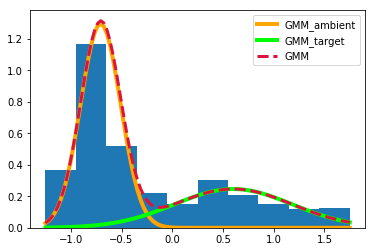

[-0.6439393939393939, 0.6893939393939394]


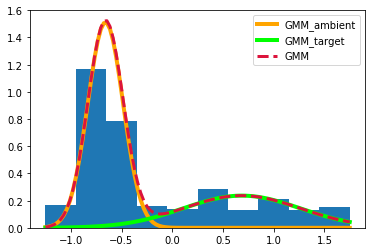

[-1.0277777777777777, 0.44949494949494984]


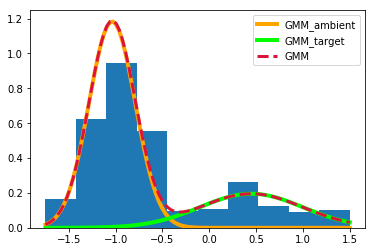

[-0.7777777777777777, 0.4368686868686871]


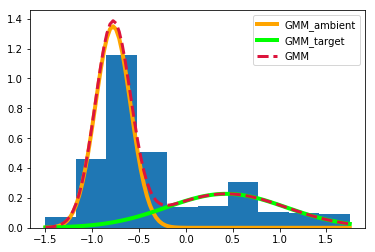

[-0.23484848484848486, 1.128787878787879]


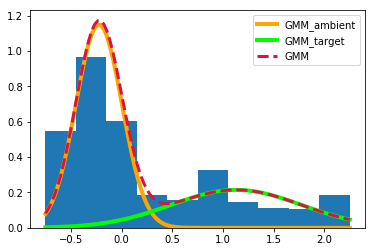

[-0.31060606060606055, 1.0025252525252526]


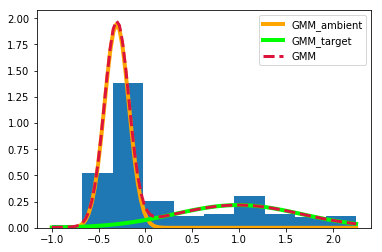

[-0.6666666666666666, 0.7272727272727273]


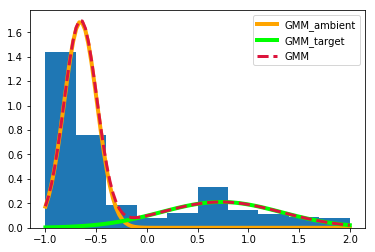

[-0.5151515151515151, 0.8181818181818183]


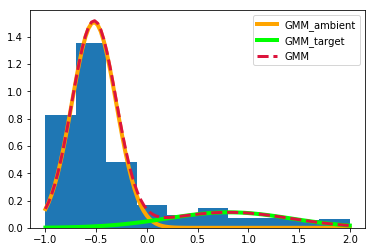

[-0.015151515151515138, 1.1666666666666667]


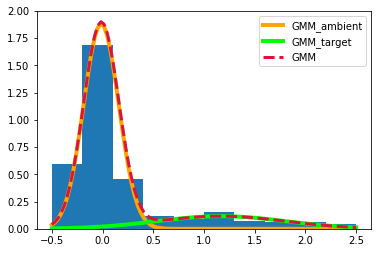

[-1.0454545454545454, 0.2272727272727273]


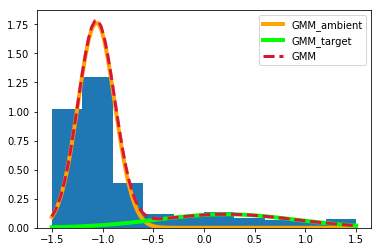

In [214]:
# i = 165
for i in range(108,145):
    gmm = GaussianMixture(n_components = 2)
    gmm = gmm.fit(X=lbicubic[i].reshape(-1,1))
    gmm_x = np.linspace(np.amin(lbicubic[i]),np.amax(lbicubic[i]),100)
#     gmm_x = np.arange(np.amin(lbicubic[i]),np.amax(lbicubic[i]),0.25)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
    gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
    if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
        gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
    print([gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)],gmm_x[np.argmax(gmm_y2[:,1]*gmm_y)]])
    fig, ax = plt.subplots()
    ax.hist(lbicubic[i], bins=10, density=True)
    ax.plot(gmm_x, gmm_y2[:,0]*gmm_y, color="orange", lw=4, label="GMM_ambient")
    ax.plot(gmm_x, gmm_y2[:,1]*gmm_y, color="lime", lw=4, label="GMM_target")
    ax.plot(gmm_x, gmm_y, color="crimson", lw=3, label="GMM", ls = "--")
#     ax.plot(gmm_x, gmm_y2[1]*gmm_y.reshape(-1,1), color="green", lw=4, label="GMM_grouping")

    plt.legend()

    plt.show()

In [123]:
np.amin(lbicubic[165])

-0.5

In [84]:
en(lbicubic)

344

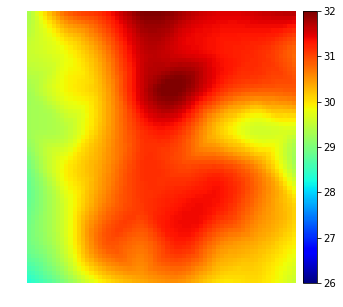

32.05516953216227

In [263]:
show_temp(interpol[0,2,3])

[[29.35 30.89 31.1  31.1  31.1  31.1  31.1  31.1 ]
 [29.55 29.86 30.61 31.1  31.1  31.1  31.1  30.91]
 [29.29 29.88 30.35 31.1  31.1  31.1  30.99 31.01]
 [29.27 29.47 30.33 31.1  31.1  30.22 29.62 29.69]
 [28.96 29.92 30.48 31.1  31.09 31.09 30.59 29.34]
 [28.85 29.69 30.66 31.1  31.1  31.1  30.8  30.12]
 [28.93 29.66 30.99 30.86 31.1  30.69 30.37 29.94]
 [28.38 29.11 30.   30.4  30.54 30.05 30.06 29.57]]
[[0.   0.32 1.   1.   1.   1.   1.   1.  ]
 [0.   0.   0.   1.   1.   1.   1.   0.37]
 [0.   0.   0.   1.   1.   1.   0.52 0.56]
 [0.   0.   0.   1.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.85 0.91 0.   0.  ]
 [0.   0.   0.02 1.   1.   1.   0.19 0.  ]
 [0.   0.   0.52 0.28 1.   0.06 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]
[[29.35 31.37 32.6  32.6  32.6  32.6  32.6  32.6 ]
 [29.55 29.86 30.61 32.6  32.6  32.6  32.6  31.47]
 [29.29 29.88 30.35 32.6  32.6  32.6  31.77 31.86]
 [29.27 29.47 30.33 32.6  32.6  30.22 29.62 29.69]
 [28.96 29.92 30.48 32.6  32.36 32.47 30.5

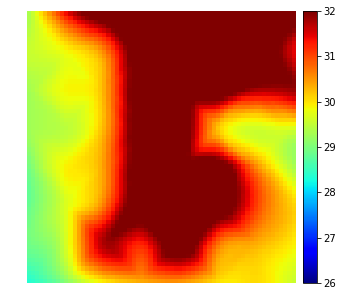

33.00667595236482

In [268]:
_x1 = interpol[0,2,3]
print(_x.round(2))
_xx = amax.reshape(4,4,36)[1,2,3]
_x = np.clip((_x1-30.14-0.5)/(_xx-30.14-0.5),0,1)
print(_x.round(2))
_x = _x*(_xx+1.5) + (1-_x)*(_x1)
print(_x.round(2))
show_temp(_x)

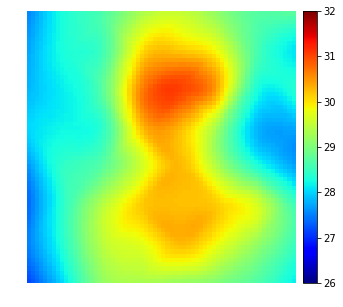

31.09688534082924

In [249]:
show_temp(interpol[1,2,3])

[[27.55 28.34 28.78 30.33 30.71 29.89 28.88 28.9 ]
 [27.75 28.31 28.61 31.54 31.76 31.2  28.7  28.11]
 [27.84 28.18 29.08 32.25 32.57 31.9  28.33 28.35]
 [28.02 28.22 28.48 31.78 31.85 30.04 27.87 27.74]
 [27.66 28.47 29.03 30.86 31.83 30.33 28.39 27.74]
 [27.4  28.49 30.5  31.68 31.78 31.63 30.93 28.57]
 [27.53 28.46 30.56 31.08 31.82 31.17 30.04 28.54]
 [27.18 28.16 30.   30.31 30.08 29.67 28.85 28.17]]
[[0.   0.   0.02 0.3  0.38 0.21 0.04 0.04]
 [0.   0.   0.   0.58 0.65 0.49 0.01 0.  ]
 [0.   0.   0.07 0.82 0.98 0.69 0.   0.  ]
 [0.   0.   0.   0.65 0.67 0.24 0.   0.  ]
 [0.   0.   0.06 0.41 0.67 0.3  0.   0.  ]
 [0.   0.   0.34 0.62 0.65 0.61 0.43 0.  ]
 [0.   0.   0.35 0.46 0.67 0.48 0.24 0.  ]
 [0.   0.   0.23 0.29 0.25 0.17 0.04 0.  ]]
[[27.55 28.34 28.78 30.33 30.71 29.89 28.88 28.9 ]
 [27.75 28.31 28.61 31.54 31.76 31.2  28.7  28.11]
 [27.84 28.18 29.08 32.25 32.57 31.9  28.33 28.35]
 [28.02 28.22 28.48 31.78 31.85 30.04 27.87 27.74]
 [27.66 28.47 29.03 30.86 31.83 30.33 28.3

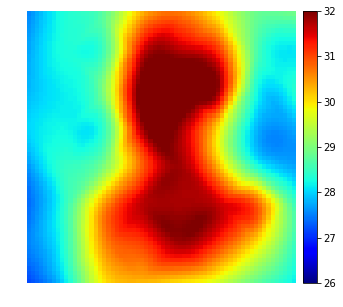

32.690330868302475

In [261]:
_x1 = interpol[1,2,3]
print(_x.round(2))
_xx = amax.reshape(4,4,36)[1,2,3]
_x = np.clip((_x1-28.12-0.5)/(_xx-28.12-0.5),0,1)
print(_x.round(2))
_x = _x*(_xx+1.5) + (1-_x)*(_x1)
print(_x.round(2))
show_temp(_x)

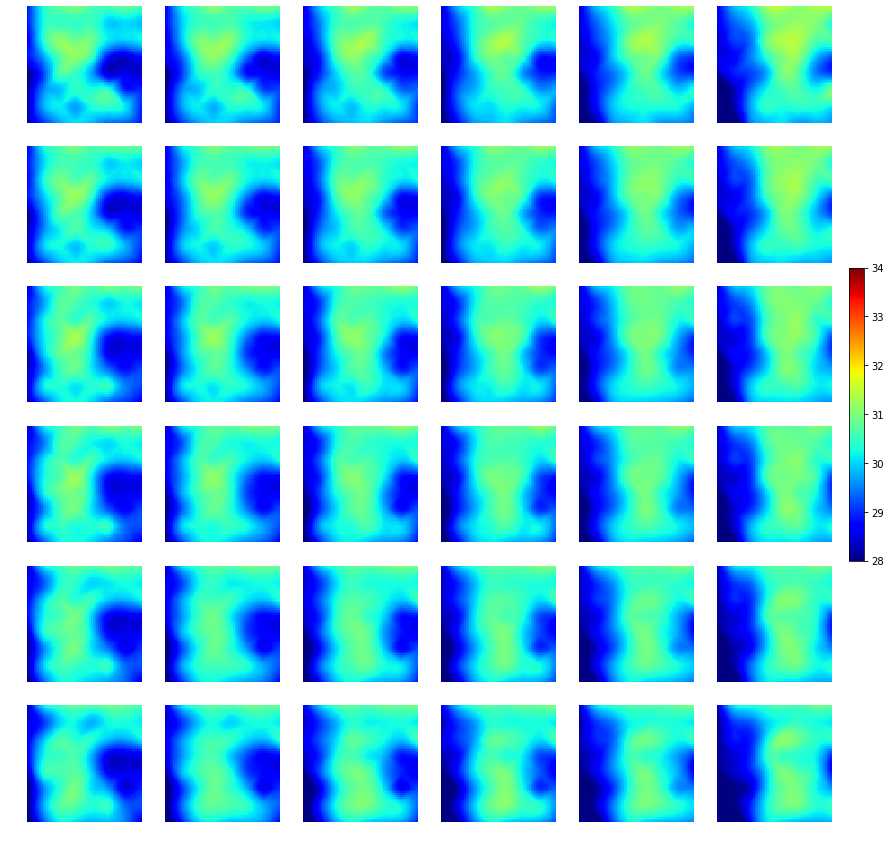

[[31.24 31.22 31.34 31.4  31.38 31.45]
 [31.24 31.19 31.18 31.17 31.2  31.31]
 [31.33 31.24 31.16 31.22 31.17 31.2 ]
 [31.24 31.15 31.12 31.16 31.08 31.12]
 [30.97 30.92 30.97 31.   30.97 31.07]
 [30.97 30.86 31.03 31.11 31.01 31.13]]


In [210]:
show_gtemp(interpol[0,3],6,None,28,34)#noshit

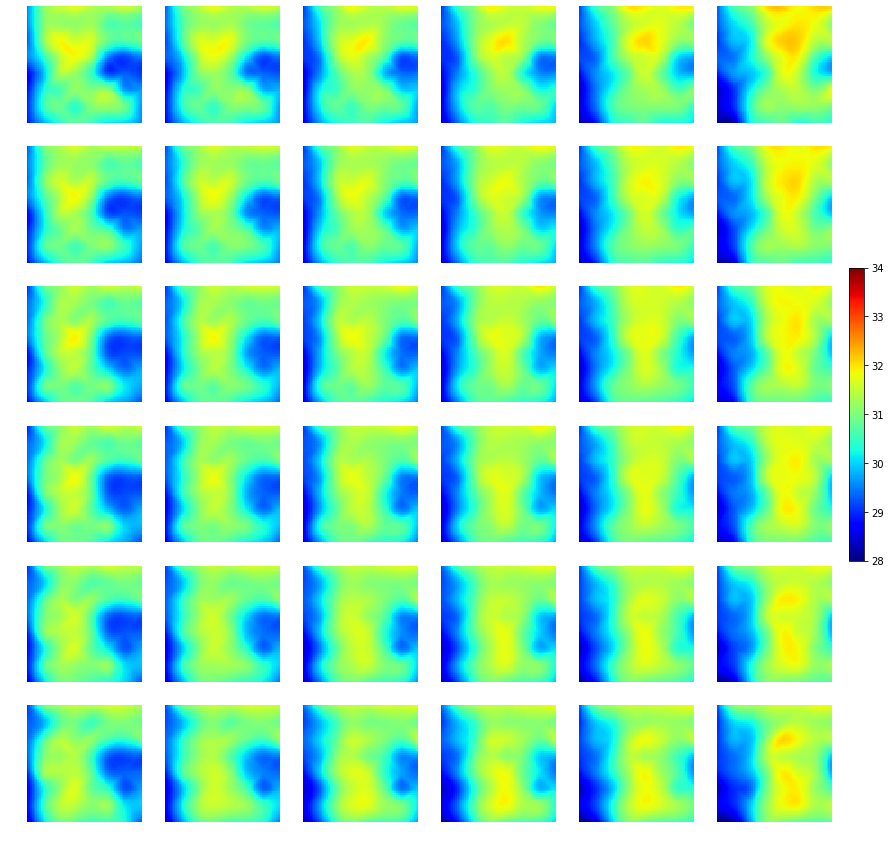

[[31.95 31.9  31.98 32.05 32.09 32.22]
 [31.9  31.85 31.84 31.86 31.94 32.11]
 [31.94 31.88 31.85 31.95 31.94 32.02]
 [31.85 31.81 31.83 31.93 31.9  31.98]
 [31.64 31.63 31.71 31.79 31.83 31.98]
 [31.71 31.62 31.8  31.93 31.9  32.11]]


In [213]:
show_gtemp(interpol[0,3],6,None,28,34)#oldshit

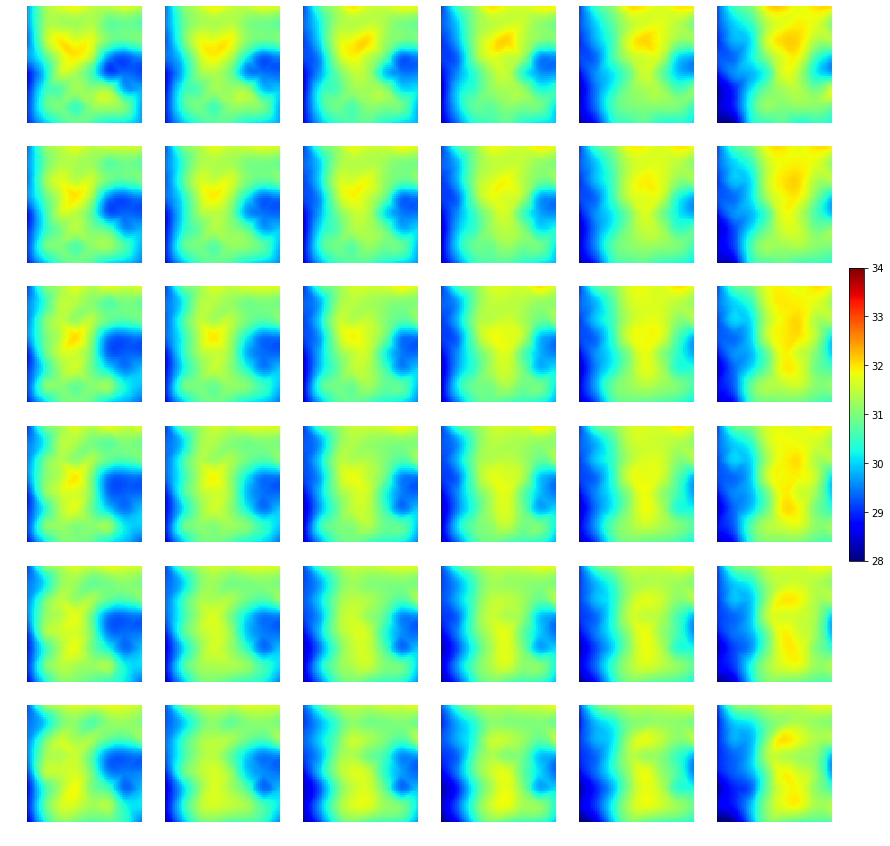

[[32.07 32.02 32.1  32.13 32.1  32.15]
 [32.01 31.96 31.93 31.93 31.98 32.11]
 [32.06 31.97 31.9  32.   32.01 32.1 ]
 [31.99 31.89 31.86 31.94 31.95 32.07]
 [31.79 31.7  31.71 31.76 31.82 32.  ]
 [31.87 31.69 31.78 31.86 31.84 32.04]]


In [243]:
show_gtemp(interpol[0,3],6,None,28,34) #newshit

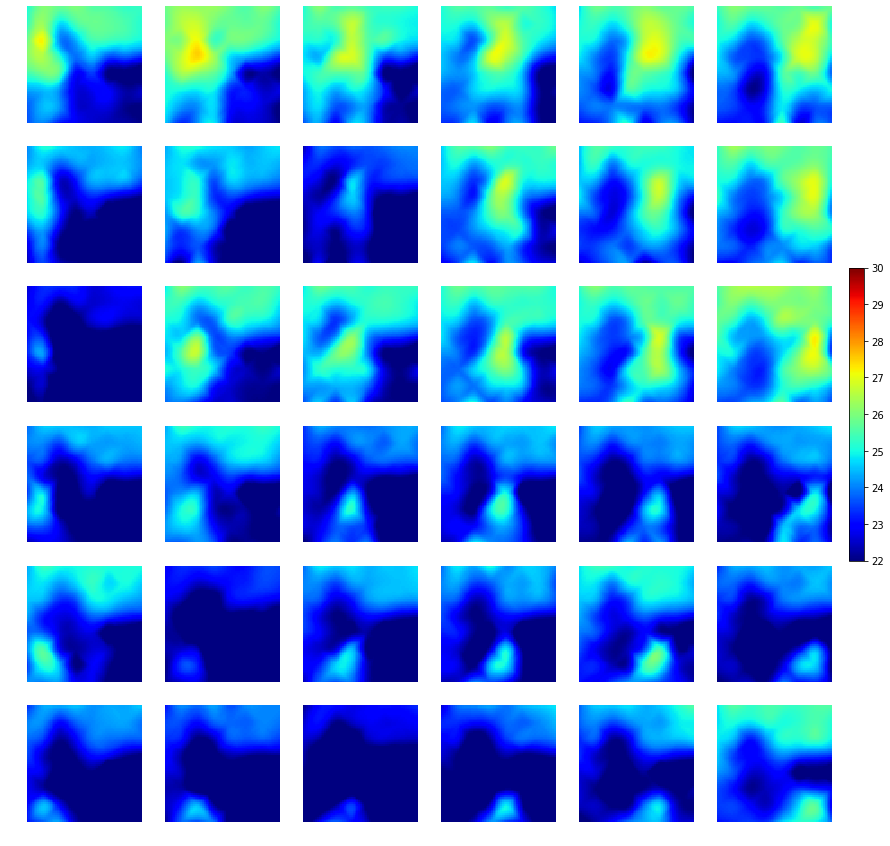

[[27.21 27.51 26.94 27.15 27.25 27.08]
 [25.62 25.61 24.82 26.91 26.83 27.06]
 [24.3  26.74 26.35 26.6  26.89 27.28]
 [25.08 25.34 25.24 25.57 25.16 25.23]
 [25.68 23.67 24.92 25.15 26.04 24.86]
 [24.56 24.69 23.68 24.97 25.56 25.81]]


In [58]:
show_gtemp(interpol[2,0],6,None,22,30) #no weight

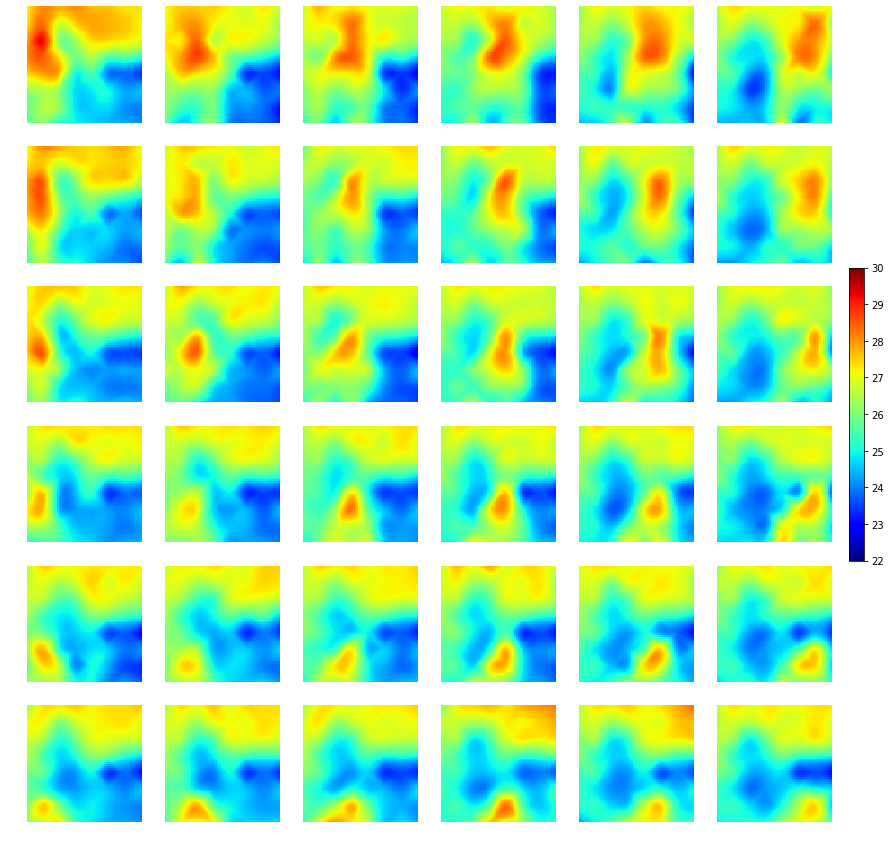

[[29.26 28.77 28.58 28.74 28.61 28.41]
 [28.63 28.08 28.17 28.52 28.52 28.23]
 [28.59 28.49 28.07 28.1  28.19 27.99]
 [27.88 27.53 28.29 28.11 27.96 27.86]
 [27.86 27.57 27.61 27.94 28.08 27.7 ]
 [27.61 28.01 27.9  28.4  28.32 27.59]]


In [64]:
show_gtemp(interpol[2,0],6,None,22,30)

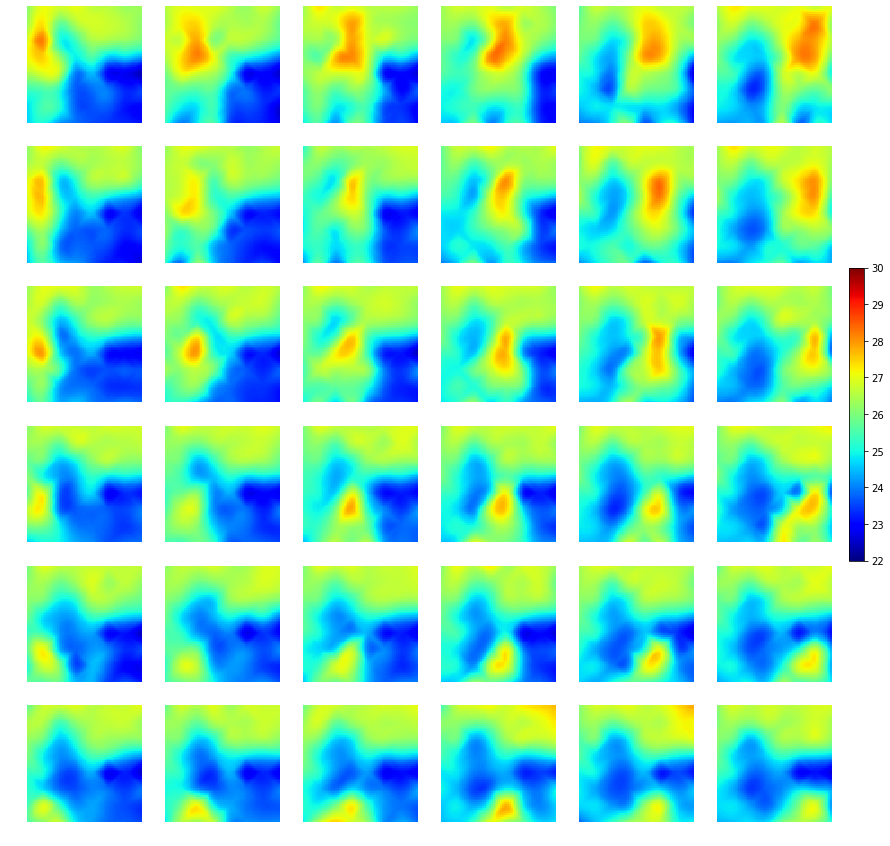

[[28.24 28.21 28.18 28.39 28.13 28.29]
 [27.71 27.54 27.63 28.09 28.42 28.08]
 [27.98 27.99 27.7  27.83 27.97 27.73]
 [27.34 27.02 27.87 27.73 27.58 27.69]
 [27.28 27.   27.07 27.4  27.6  27.33]
 [26.99 27.41 27.43 27.85 27.83 27.11]]


In [231]:
show_gtemp(interpol[2,0],6,None,22,30) #newshit

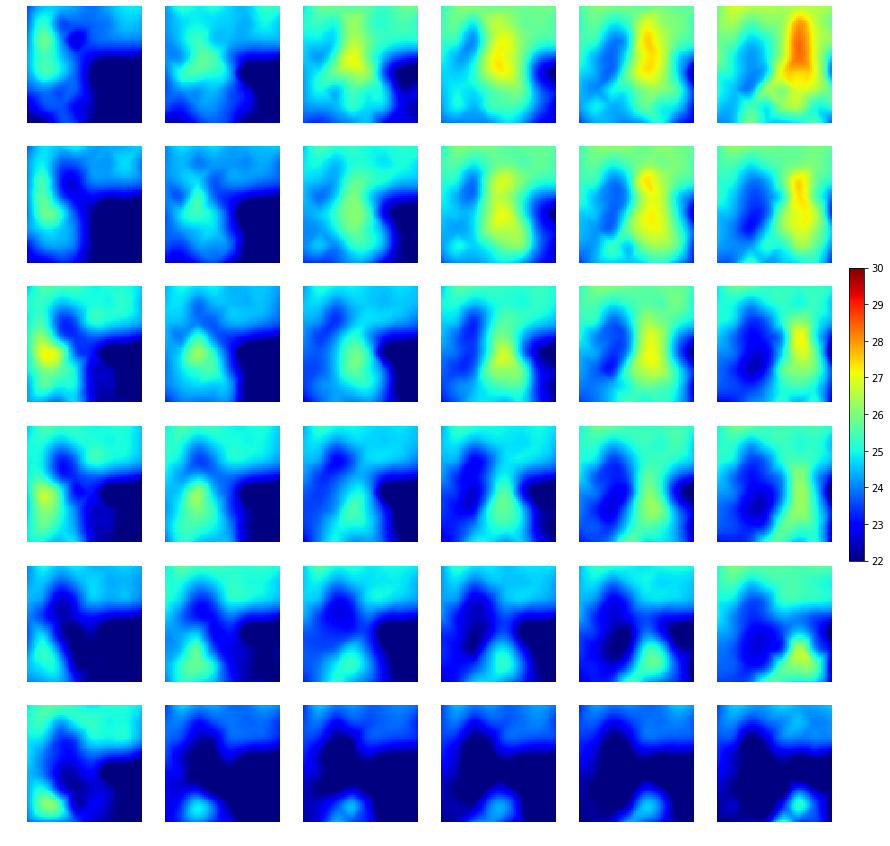

[[25.86 25.73 27.1  27.35 27.52 28.43]
 [25.87 25.46 26.12 27.06 27.37 27.51]
 [27.21 26.29 25.95 26.84 27.15 27.16]
 [26.72 26.32 25.51 25.77 26.3  26.33]
 [25.27 25.82 25.59 25.25 25.78 26.68]
 [26.16 24.91 24.47 24.37 24.62 25.2 ]]


In [51]:
show_gtemp(interpol[2,1],6,None,22,30) #no weight

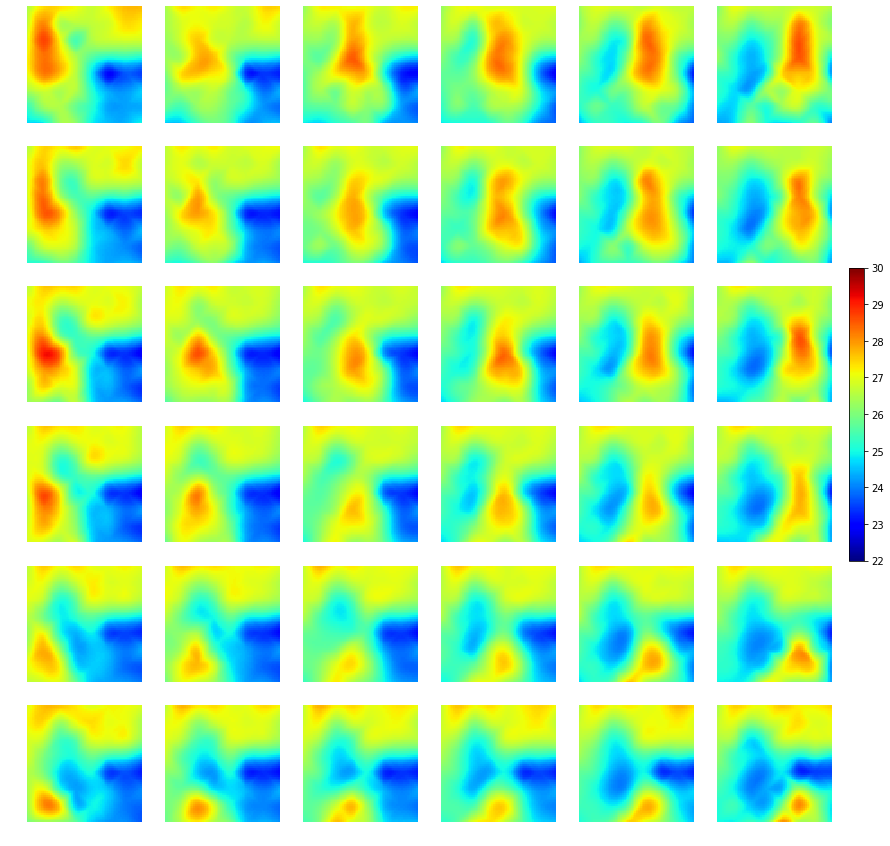

[[28.72 27.93 28.53 28.41 28.45 28.65]
 [28.56 28.02 27.9  28.16 28.18 28.33]
 [29.19 28.62 28.13 28.45 28.24 28.61]
 [28.71 28.23 27.67 27.78 27.79 27.81]
 [27.83 27.73 27.72 27.59 27.88 28.11]
 [28.24 28.06 27.75 27.59 27.83 28.1 ]]


In [54]:
show_gtemp(interpol[2,1],6,None,22,30)

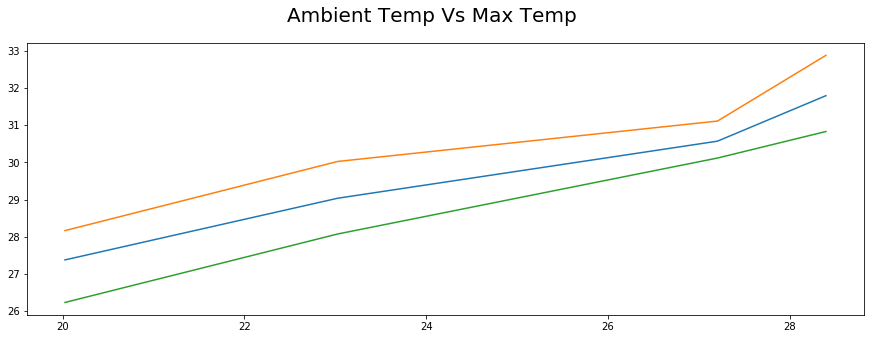

In [7]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = 0)
plt.plot(amb_temp,np.mean(center, axis = (1,2,3))+mean) 
plt.plot(amb_temp,np.amax(center, axis = (1,2,3))+mean)
plt.plot(amb_temp,np.amin(center, axis = (1,2,3))+mean)
plt.suptitle('Ambient Temp Vs Max Temp', fontsize = 20)
plt.show()

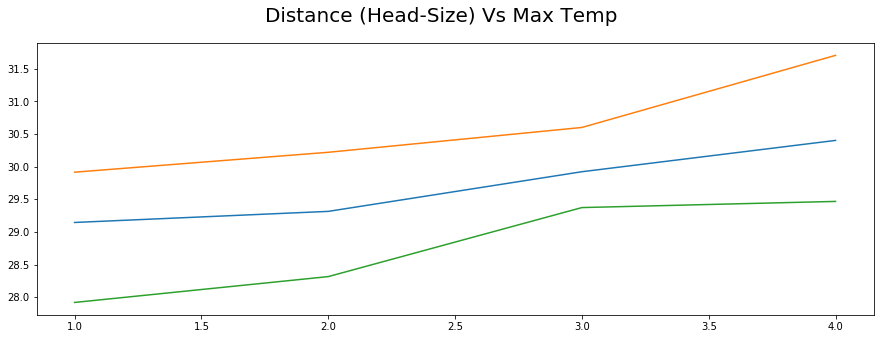

In [8]:
dis_head = np.linspace(1,4,4)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax.transpose(1,0,2,3)-np.mean(amax, axis = 1)
plt.plot(dis_head,np.mean(center, axis = (1,2,3)) + mean)
plt.plot(dis_head,np.amax(center, axis = (1,2,3)) + mean)
plt.plot(dis_head,np.amin(center, axis = (1,2,3)) + mean)
plt.suptitle('Distance (Head-Size) Vs Max Temp', fontsize = 20)
plt.show()

In [9]:
np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))

array([28.39548698, 27.20325227, 23.02636959, 20.02692516])

In [14]:
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(center, axis = (2,3))+mean
d_center.round(2)

array([[31.9 , 31.87, 31.8 , 31.95],
       [30.45, 30.4 , 30.86, 31.27],
       [28.17, 28.16, 29.53, 30.3 ],
       [26.48, 27.24, 27.81, 28.01]])

In [17]:
center = np.mean(amax, axis = (2,3))
36.5-center.round(2)

array([[ 4.6 ,  4.63,  4.7 ,  4.55],
       [ 6.05,  6.1 ,  5.64,  5.23],
       [ 8.33,  8.34,  6.97,  6.2 ],
       [10.02,  9.26,  8.69,  8.49]])

In [37]:
center = (np.max(amax, axis = (2,3))-np.amin(amax, axis = (2,3)))*0.5
center.round(2)

array([[0.35, 0.3 , 0.3 , 0.23],
       [0.41, 0.57, 0.52, 0.42],
       [0.63, 0.8 , 0.84, 0.71],
       [0.99, 0.69, 0.5 , 0.77]])

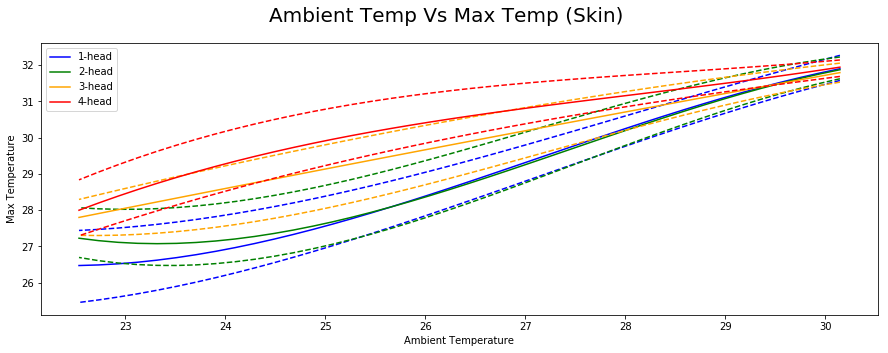

In [136]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(amax, axis = (2,3))
d_max = np.amax(amax, axis = (2,3))
d_min = np.amin(amax, axis = (2,3))
cubic = interp1d(amb_temp, d_center[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '1-head', color = 'b')
cubic = interp1d(amb_temp, d_max[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'b')
cubic = interp1d(amb_temp, d_min[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'b')

cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '2-head', color = 'g')
cubic = interp1d(amb_temp, d_max[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'g')
cubic = interp1d(amb_temp, d_min[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'g')

cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '3-head', color = 'orange')
cubic = interp1d(amb_temp, d_max[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'orange')
cubic = interp1d(amb_temp, d_min[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'orange')

cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '4-head', color = 'r')
cubic = interp1d(amb_temp, d_max[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'r')
cubic = interp1d(amb_temp, d_min[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'r')

# cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '2-head')
# cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '3-head')
# cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Ambient Temperature")
plt.show()

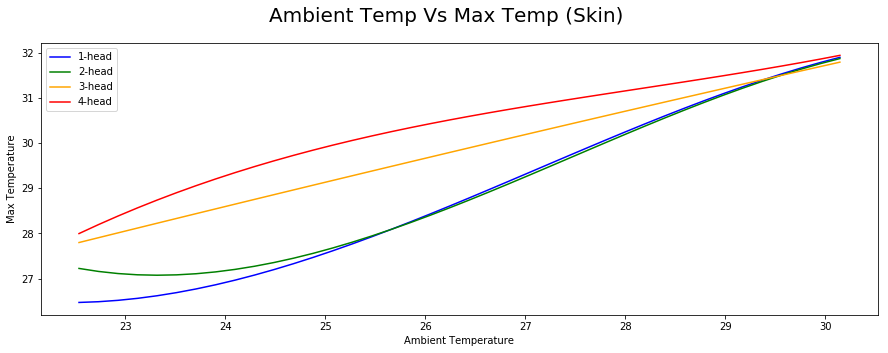

In [137]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(amax, axis = (2,3))
d_max = np.amax(amax, axis = (2,3))
d_min = np.amin(amax, axis = (2,3))
cubic = interp1d(amb_temp, d_center[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '1-head', color = 'b')


cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '2-head', color = 'g')


cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '3-head', color = 'orange')


cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '4-head', color = 'r')


# cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '2-head')
# cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '3-head')
# cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Ambient Temperature")
plt.show()

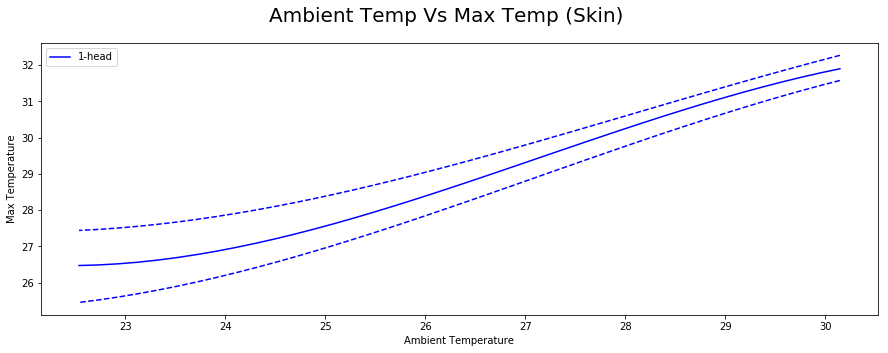

In [138]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(amax, axis = (2,3))
d_max = np.amax(amax, axis = (2,3))
d_min = np.amin(amax, axis = (2,3))
cubic = interp1d(amb_temp, d_center[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '1-head', color = 'b')
cubic = interp1d(amb_temp, d_max[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'b')
cubic = interp1d(amb_temp, d_min[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'b')

# cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '2-head')
# cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '3-head')
# cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Ambient Temperature")
plt.show()

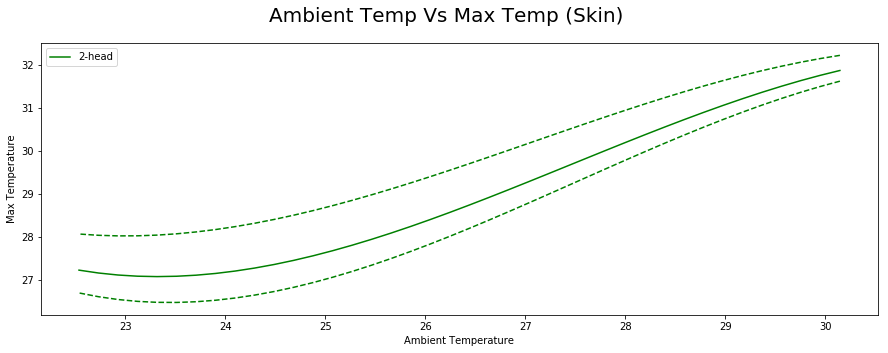

In [139]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(amax, axis = (2,3))
d_max = np.amax(amax, axis = (2,3))
d_min = np.amin(amax, axis = (2,3))

cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '2-head', color = 'g')
cubic = interp1d(amb_temp, d_max[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'g')
cubic = interp1d(amb_temp, d_min[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'g')

# cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '2-head')
# cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '3-head')
# cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Ambient Temperature")
plt.show()

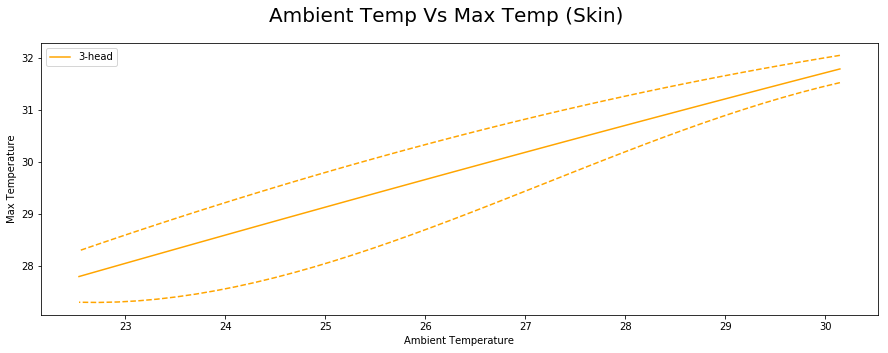

In [140]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(amax, axis = (2,3))
d_max = np.amax(amax, axis = (2,3))
d_min = np.amin(amax, axis = (2,3))


cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '3-head', color = 'orange')
cubic = interp1d(amb_temp, d_max[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'orange')
cubic = interp1d(amb_temp, d_min[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'orange')


# cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '2-head')
# cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '3-head')
# cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Ambient Temperature")
plt.show()

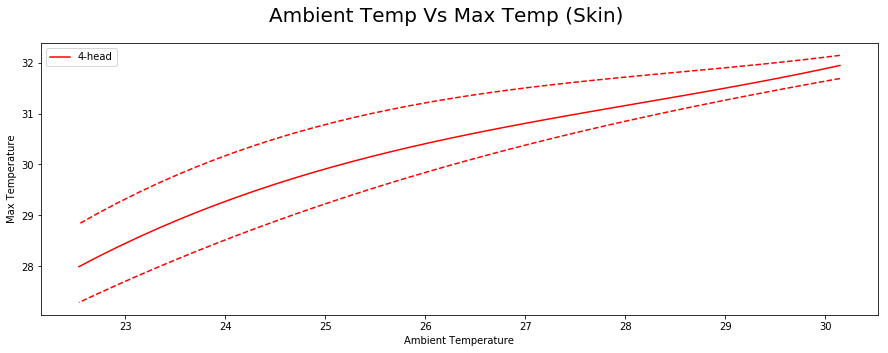

In [141]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(amax, axis = (2,3))
d_max = np.amax(amax, axis = (2,3))
d_min = np.amin(amax, axis = (2,3))


cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '4-head', color = 'r')
cubic = interp1d(amb_temp, d_max[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'r')
cubic = interp1d(amb_temp, d_min[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), ls = '--', color = 'r')

# cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '2-head')
# cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '3-head')
# cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
# plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Ambient Temperature")
plt.show()

No handles with labels found to put in legend.


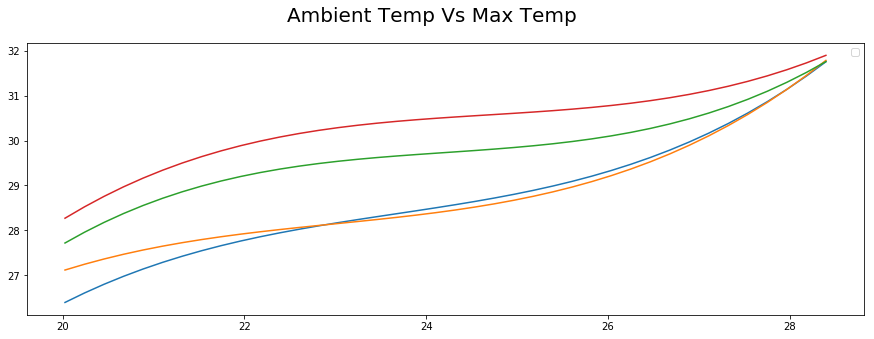

In [11]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(center, axis = (2,3)) + mean
cubic = interp1d(amb_temp, d_center[:,0], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp', fontsize = 20)
plt.show()

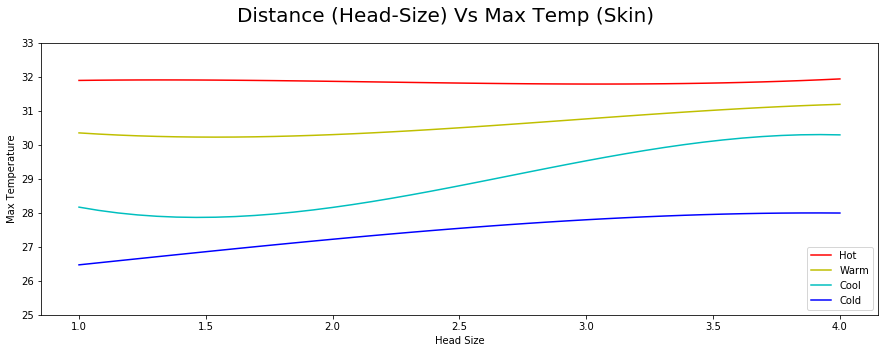

In [159]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Hot', color= 'r')
cubic = interp1d(dis_head, d_center[1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Warm', color= 'y')
cubic = interp1d(dis_head, d_center[2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cool', color= 'c')
cubic = interp1d(dis_head, d_center[3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cold', color= 'b')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Head Size")
plt.ylim([25, 33])
plt.show()

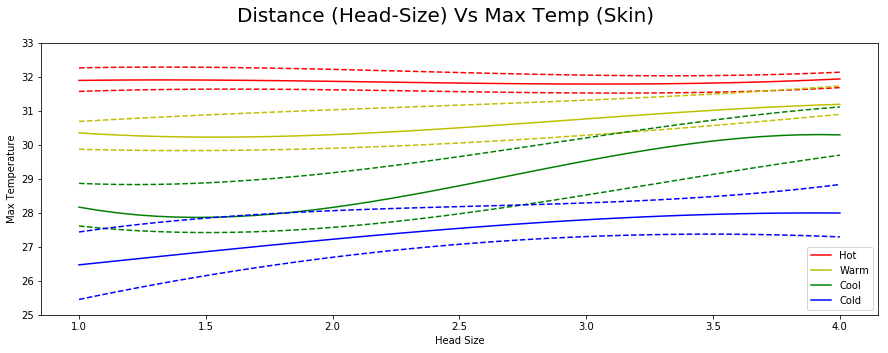

In [160]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Hot', color= 'r')
cubic = interp1d(dis_head, d_max[0], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'r', ls = '--')
cubic = interp1d(dis_head, d_min[0], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'r', ls = '--')

cubic = interp1d(dis_head, d_center[1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Warm', color= 'y')
cubic = interp1d(dis_head, d_max[1], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'y', ls = '--')
cubic = interp1d(dis_head, d_min[1], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'y', ls = '--')

cubic = interp1d(dis_head, d_center[2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cool', color= 'g')
cubic = interp1d(dis_head, d_max[2], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'g', ls = '--')
cubic = interp1d(dis_head, d_min[2], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'g', ls = '--')

cubic = interp1d(dis_head, d_center[3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cold', color= 'b')
cubic = interp1d(dis_head, d_max[3], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'b', ls = '--')
cubic = interp1d(dis_head, d_min[3], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'b', ls = '--')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Head Size")
plt.ylim([25, 33])
plt.show()

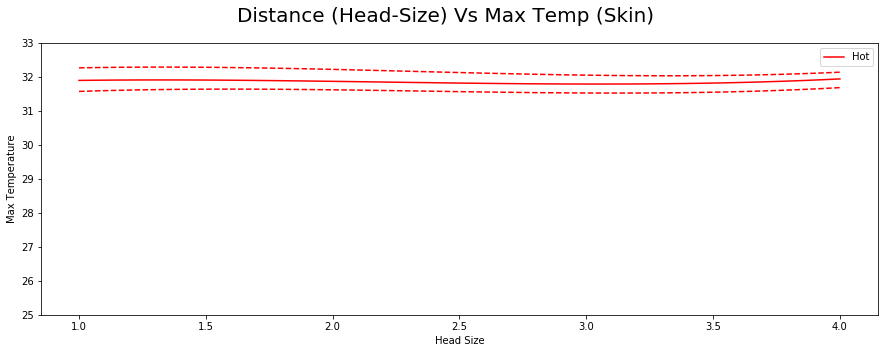

In [158]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Hot', color= 'r')
cubic = interp1d(dis_head, d_max[0], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'r', ls = '--')
cubic = interp1d(dis_head, d_min[0], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'r', ls = '--')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Head Size")
plt.ylim([25, 33])
plt.show()

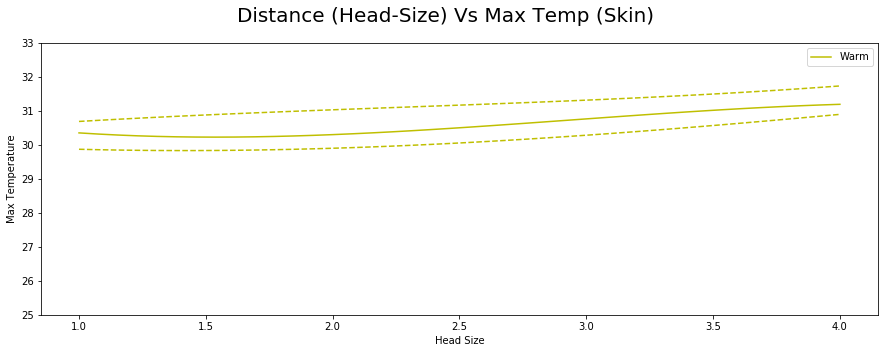

In [157]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Warm', color= 'y')
cubic = interp1d(dis_head, d_max[1], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'y', ls = '--')
cubic = interp1d(dis_head, d_min[1], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'y', ls = '--')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Head Size")
plt.ylim([25, 33])
plt.show()

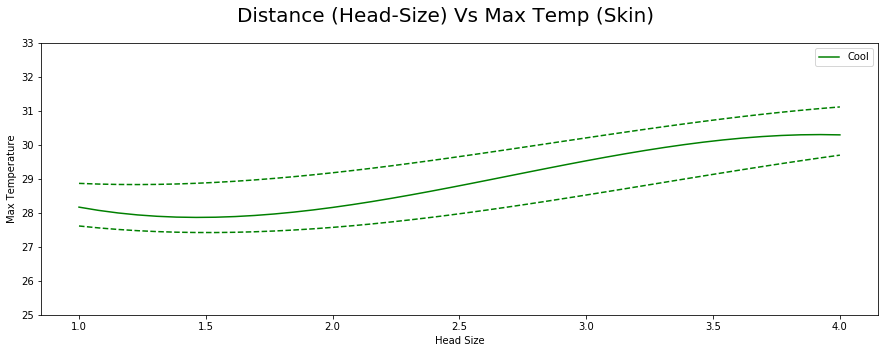

In [156]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cool', color= 'g')
cubic = interp1d(dis_head, d_max[2], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'g', ls = '--')
cubic = interp1d(dis_head, d_min[2], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'g', ls = '--')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Head Size")
plt.ylim([25, 33])
plt.show()

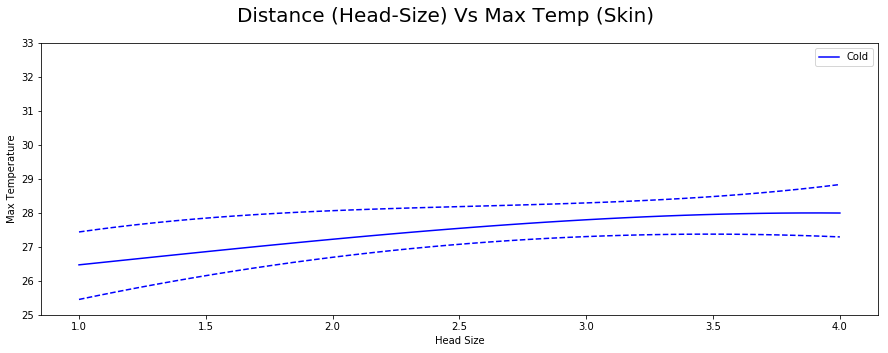

In [155]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cold', color= 'b')
cubic = interp1d(dis_head, d_max[3], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'b', ls = '--')
cubic = interp1d(dis_head, d_min[3], kind='cubic')
plt.plot(x_new,cubic(x_new), color= 'b', ls = '--')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp (Skin)', fontsize = 20)
plt.ylabel("Max Temperature")
plt.xlabel("Head Size")
plt.ylim([25, 33])
plt.show()

In [9]:
center = amax-np.mean(amax, axis = (0,1))
amb_dis = np.mean(center, axis = (2,3))
amb_dis.round(2)

array([[ 2.14,  2.11,  2.04,  2.19],
       [ 0.69,  0.64,  1.1 ,  1.51],
       [-1.59, -1.6 , -0.23,  0.54],
       [-3.29, -2.54, -1.96, -1.76]])

In [14]:
center = amax-np.mean(amax, axis = (0,1))
amb_dis = np.mean(center, axis = (2,3))
amb_dis.round(2)

array([[ 2.06,  2.09,  2.06,  2.2 ],
       [ 0.56,  0.51,  0.98,  1.46],
       [-1.52, -1.54, -0.16,  0.59],
       [-3.3 , -2.58, -1.98, -1.42]])

In [15]:
center = amax.transpose(2,3,0,1)-np.mean(amax, axis = (2,3))
pos = np.mean(center, axis = (2,3))
pos.round(2)

array([[ 0.36,  0.16,  0.12,  0.22,  0.2 ,  0.33],
       [ 0.04, -0.12, -0.06, -0.01,  0.01,  0.1 ],
       [ 0.1 , -0.06, -0.09,  0.03, -0.04,  0.06],
       [-0.01, -0.22, -0.08,  0.04, -0.  ,  0.1 ],
       [-0.22, -0.32, -0.22, -0.09, -0.07,  0.04],
       [-0.12, -0.21, -0.11,  0.02, -0.02,  0.15]])

In [10]:
diff = 36.5-mean
diff

6.740361118467977

In [17]:
amb_temp

array([28.39548698, 27.20325227, 23.02636959, 20.02692516])

In [30]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
# amb_temp = np.array([28.39548698, 27.20325227, 23.02636959, 20.02692516])
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
# amb_dis = np.array([[ 2.2 ,  2.47,  2.44,  2.01],
#        [ 0.62,  0.74,  1.  ,  1.84],
#        [-1.85, -1.38, -0.35,  0.97],
#        [-2.91, -3.16, -2.83, -1.81]])
amb_dis = np.array([[ 2.14,  2.11,  2.04,  2.19],
       [ 0.69,  0.64,  1.1 ,  1.51],
       [-1.59, -1.6 , -0.23,  0.54],
       [-3.29, -2.54, -1.96, -1.76]])
for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    print(poly_dis[i].round(2))
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.804515467387837).round(2)
    
# vert = np.linspace(1,4,4)
# poly_vert = np.zeros((4,4))
# x_vert = np.linspace(1,4,40)
# for i in range(4):
#     cubic = interp1d(dis_head, amb_dis[i], kind='cubic')
#     poly_dis[i] = np.polyfit(x_dis,cubic(x_dis),3)

[ 0.04 -0.28  0.51  1.87]
[-0.09  0.82 -1.84  1.81]
[-0.33  2.67 -5.71  1.78]
[-0.04  0.13  0.62 -4.  ]


In [ ]:
[ 0.04 -0.26  0.54  1.74]
[-0.08  0.77 -1.77  1.64]
[-0.34  2.73 -5.84  1.93]
[ 0.01 -0.14  1.05 -4.22]


In [120]:
dis_head = np.linspace(1,4,4)
poly_dis2 = np.zeros((4,4))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
amb_dis2 = np.array([[ 4.6 ,  4.63,  4.7 ,  4.55],
       [ 6.05,  6.1 ,  5.64,  5.23],
       [ 8.33,  8.34,  6.97,  6.2 ],
       [10.02,  9.26,  8.69,  8.49]])

for i in range(4):
    poly_dis2[i] = np.polyfit(dis_head,amb_dis2[i],3)
    
def get_bodytemp2(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis2[i,0]*(distance**3) + poly_dis2[i,1]*(distance**2) + poly_dis2[i,2]*(distance) + poly_dis2[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp + ans).round(2)

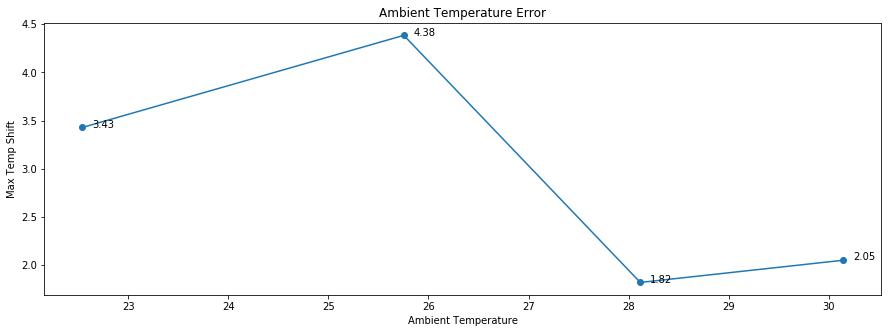

In [122]:
x=[30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674]
y=[2.0520057885509253,1.8216599874042636,4.384944194607751,3.4291026310700303]
plt.figure(figsize=(15, 5))
plt.plot(x,y,marker="o")
plt.xlabel("Ambient Temperature")
plt.ylabel("Max Temp Shift")
plt.title("Ambient Temperature Error")
for i,j in zip(x,y):
    plt.annotate(str(round(j,2)),xy=(i+0.1,j))
plt.show()

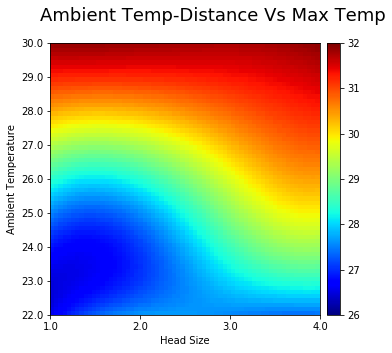

[26.48, 31.9]


In [121]:
_y = np.linspace(30,22,64)
_x = np.linspace(1,4,64)
_btimg = np.ones((64,64))
for i in range(64):
    for j in range(64):
        _btimg[i,j] = 36.5-get_bodytemp2(0,_y[i],_x[j])

plt.figure(figsize=(6,5))
pcm = plt.pcolormesh(np.flip(_btimg,0), cmap='jet',vmin = 26, vmax = 32)
plt.colorbar(pcm, fraction=0.175,pad=0.02)
plt.xticks(np.linspace(0,64,4),np.linspace(1,4,4).round(2))
plt.yticks(np.linspace(0,64,9),np.linspace(22,30,9))
plt.suptitle('Ambient Temp-Distance Vs Max Temp', fontsize = 18)
plt.ylabel("Ambient Temperature")
plt.xlabel("Head Size")
plt.show()
print([np.amin(_btimg),np.amax(_btimg)])
# print(pcm.axes)

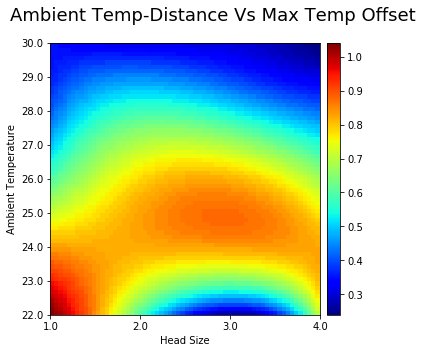

[0.24, 1.04]


In [118]:
_y = np.linspace(30,22,64)
_x = np.linspace(1,4,64)
_btimg = np.ones((64,64))
for i in range(64):
    for j in range(64):
        _btimg[i,j] = get_bodytemp2(0,_y[i],_x[j])

plt.figure(figsize=(6,5))
pcm = plt.pcolormesh(np.flip(_btimg,0), cmap='jet')
plt.colorbar(pcm, fraction=0.175,pad=0.02)
plt.xticks(np.linspace(0,64,4),np.linspace(1,4,4).round(2))
plt.yticks(np.linspace(0,64,9),np.linspace(22,30,9))
plt.suptitle('Ambient Temp-Distance Vs Max Temp Offset', fontsize = 18)
plt.ylabel("Ambient Temperature")
plt.xlabel("Head Size")
plt.show()
print([np.amin(_btimg),np.amax(_btimg)])
# print(pcm.axes)

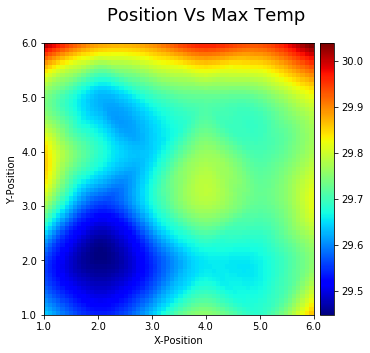

[29.44737768747125, 30.039886053529514]
0.5925083660582651


In [163]:
points2 = [(math.floor(ix / 6), (ix % 6)) for ix in range(0, 36)]
grid_x2, grid_y2 = np.mgrid[0:5:64j, 0:5:64j]

plt.figure(figsize=(6,5))
pp = np.mean(amax, axis = (0,1))
bicubic = griddata(points2, pp.reshape(-1), (grid_x2, grid_y2), method='cubic')
pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet')
plt.colorbar(pcm, fraction=0.175,pad=0.02)
plt.xticks(np.linspace(0,64,6),np.linspace(1,6,6))
plt.yticks(np.linspace(0,64,6),np.linspace(1,6,6))
plt.suptitle('Position Vs Max Temp', fontsize = 18)
plt.ylabel("Y-Position")
plt.xlabel("X-Position")
plt.show()
print([np.amin(bicubic),np.amax(bicubic)])
print((np.amax(bicubic)-np.amin(bicubic)))

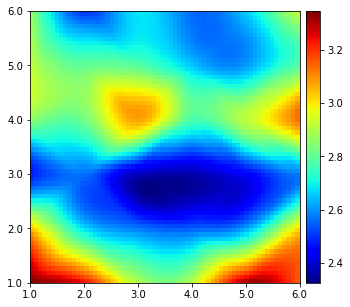

[2.3244382334100497, 3.3473064815677773]


In [86]:
points2 = [(math.floor(ix / 6), (ix % 6)) for ix in range(0, 36)]
grid_x2, grid_y2 = np.mgrid[0:5:64j, 0:5:64j]

plt.figure(figsize=(6,5))
pp = (np.amax(amax, axis = (0,1))- np.amin(amax, axis = (0,1)))*0.5
bicubic = griddata(points2, pp.reshape(-1), (grid_x2, grid_y2), method='cubic')
pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet')
plt.colorbar(pcm, fraction=0.175,pad=0.02)
plt.xticks(np.linspace(0,64,6),np.linspace(1,6,6))
plt.yticks(np.linspace(0,64,6),np.linspace(1,6,6))
plt.suptitle('Position Vs Max Temp Offset', fontsize = 18)
plt.ylabel("Y-Position")
plt.xlabel("X-Position")
plt.show()
print([np.amin(bicubic),np.amax(bicubic)])

In [32]:
get_bodytemp(31.53,27.99,4)

36.87

In [33]:
get_bodytemp2(31.53,27.99,4)

36.8

In [29]:
get_bodytemp(28.49,25.68,1.27)

37.08

In [30]:
get_bodytemp(28.34,22.40,2.62)

37.35

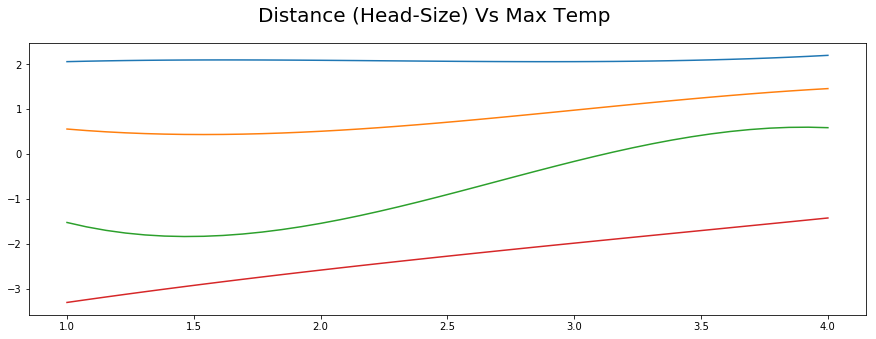

2.147360000000001
1.387679999999997
0.5878399999999715
-1.5326400000000007


In [22]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for i in range(4):
    plt.plot(x_new,poly_dis[i,0]*(x_new**3) + poly_dis[i,1]*x_new**2 + poly_dis[i,2]*x_new + poly_dis[i,3])
plt.suptitle('Distance (Head-Size) Vs Max Temp', fontsize = 20)
plt.show()

for i in range(4):
   print(poly_dis[i,0]*(3.8**3) + poly_dis[i,1]*3.8**2 + poly_dis[i,2]*3.8 + poly_dis[i,3])

In [23]:
np.median(interpol[1,2,3].round(2))

28.634999999999998

In [24]:
np.amin(interpol[0,3,35].round(2))

27.83

In [25]:
amax[0,3,5,5]

32.10548476249596

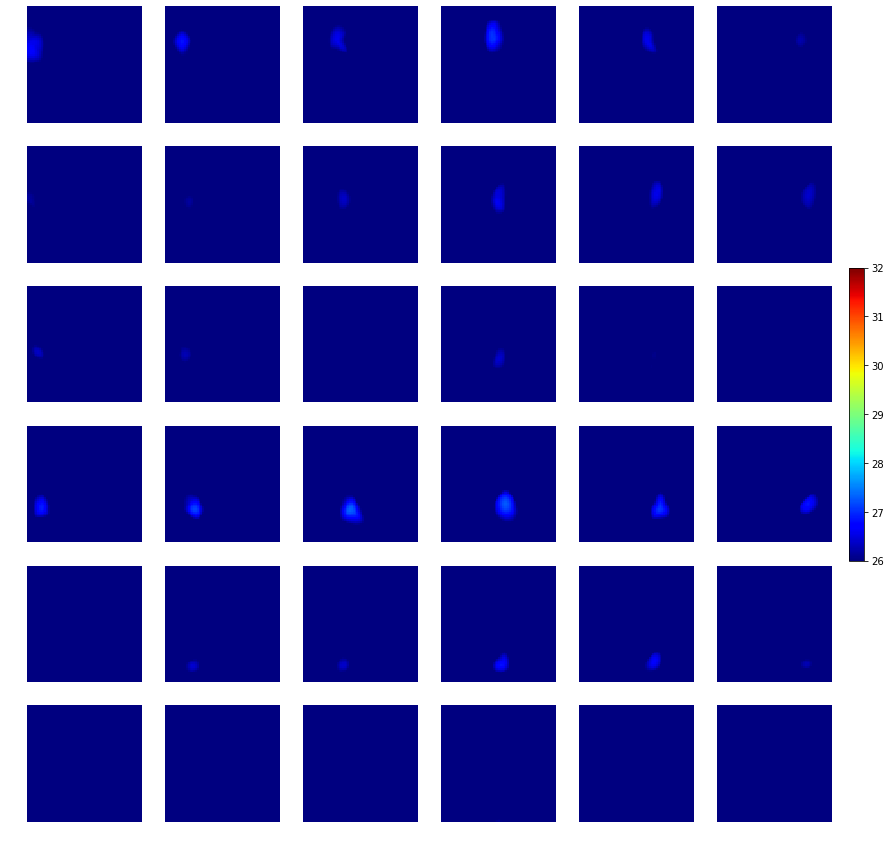

[[26.7  26.86 26.59 27.03 26.58 26.25]
 [26.18 26.16 26.38 26.62 26.56 26.4 ]
 [26.36 26.29 25.77 26.42 26.07 25.81]
 [26.91 27.14 27.33 27.27 27.08 26.84]
 [25.74 26.42 26.4  26.82 26.67 26.27]
 [25.36 25.61 26.04 26.09 25.55 25.72]]


In [77]:
show_gtemp(interpol[3,0],6)

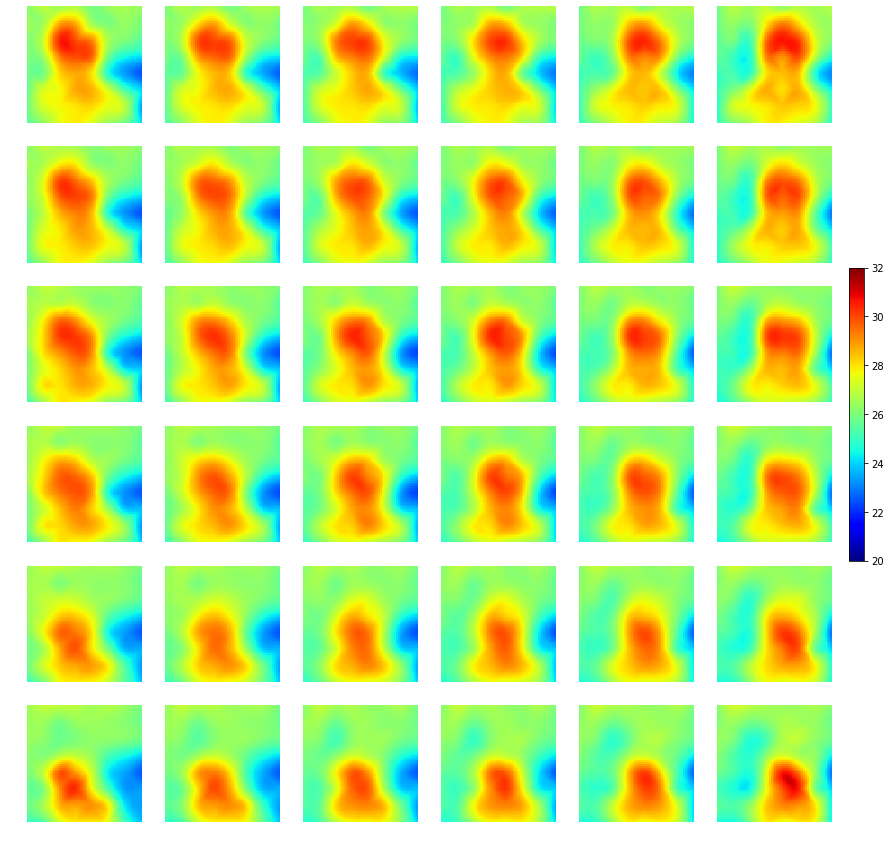

[[30.75 30.28 30.32 30.46 30.53 30.68]
 [30.41 30.08 30.2  30.31 30.29 30.28]
 [30.39 30.33 30.51 30.59 30.49 30.49]
 [29.93 30.01 30.25 30.3  30.18 30.14]
 [29.88 29.62 29.82 29.94 30.02 30.41]
 [30.42 29.98 30.03 30.28 30.42 31.22]]


In [27]:
show_gtemp(interpol[2,3],6,None,20,32)

In [28]:
b = amax.tolist() # nested lists with same data, indices
file_path = "amax.json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [73]:
for i in range(4):
    for j in range(4):
        print([i,j,get_bodytemp(amax[i,j,0,0],np.amin(interpol[i,j,0]),j+1)])

[0, 0, 36.01]
[0, 1, 35.98]
[0, 2, 35.81]
[0, 3, 36.33]
[1, 0, 36.49]
[1, 1, 36.7]
[1, 2, 36.49]
[1, 3, 36.64]
[2, 0, 37.46]
[2, 1, 37.06]
[2, 2, 37.24]
[2, 3, 37.15]
[3, 0, 36.53]
[3, 1, 37.33]
[3, 2, 37.78]
[3, 3, 38.16]


In [79]:
for i in range(4):
    for j in range(4):
        print([i,j,get_bodytemp(np.mean(amax[i,j]),np.mean(np.amin(interpol[i,j], axis = (0,1))),j+1)])

[0, 0, 35.98]
[0, 1, 35.6]
[0, 2, 35.65]
[0, 3, 35.7]
[1, 0, 36.43]
[1, 1, 36.34]
[1, 2, 36.37]
[1, 3, 36.32]
[2, 0, 36.3]
[2, 1, 36.32]
[2, 2, 36.37]
[2, 3, 36.26]
[3, 0, 36.05]
[3, 1, 36.18]
[3, 2, 35.69]
[3, 3, 35.31]


In [75]:
for i in range(4):
    for j in range(4):
        print([i,j,get_bodytemp(np.mean(amax[i,j]),np.mean(np.amin(interpol[i,j], axis = (0,1))),j+1)])

[0, 0, 35.98]
[0, 1, 35.6]
[0, 2, 35.65]
[0, 3, 35.7]
[1, 0, 36.43]
[1, 1, 36.34]
[1, 2, 36.37]
[1, 3, 36.32]
[2, 0, 36.3]
[2, 1, 36.32]
[2, 2, 36.37]
[2, 3, 36.26]
[3, 0, 36.05]
[3, 1, 36.18]
[3, 2, 35.69]
[3, 3, 35.31]


In [72]:
for t in range(4):
    for d in range(4):
        m = np.ones(36)
        for i in range(36):
            a = amax.reshape(4,4,-1)[t,d,i]
            b = np.amin(interpol[t,d,i])
            m[i] = get_bodytemp(a,b,d+1)
            print([a.round(2),b.round(2),m[i]])
        print([t,d,np.mean(m)])
        print("")

[31.46, 28.52, 36.01]
[31.77, 28.39, 36.53]
[31.22, 28.15, 36.33]
[31.78, 28.32, 36.64]
[31.78, 28.41, 36.51]
[32.01, 28.55, 36.51]
[31.43, 28.93, 35.27]
[31.31, 28.3, 36.2]
[31.89, 28.45, 36.55]
[31.82, 28.3, 36.71]
[31.76, 28.24, 36.73]
[31.67, 28.22, 36.67]
[31.92, 28.93, 35.76]
[31.79, 28.59, 36.22]
[31.8, 28.35, 36.61]
[31.65, 28.4, 36.39]
[31.48, 28.22, 36.49]
[31.75, 28.31, 36.63]
[31.62, 29.12, 35.11]
[31.73, 28.75, 35.89]
[31.63, 28.39, 36.38]
[31.88, 28.38, 36.66]
[31.79, 28.07, 37.01]
[31.99, 28.29, 36.89]
[31.61, 28.84, 35.61]
[31.75, 28.3, 36.64]
[31.69, 28.2, 36.73]
[31.84, 28.14, 36.96]
[31.58, 28.11, 36.74]
[32.22, 28.52, 36.77]
[31.75, 28.53, 36.28]
[32.05, 28.51, 36.61]
[32.09, 28.4, 36.83]
[31.75, 28.27, 36.68]
[32.07, 28.11, 37.23]
[31.74, 28.26, 36.69]
[0, 0, 36.4575]

[31.63, 28.61, 35.98]
[31.6, 28.46, 36.22]
[31.54, 28.41, 36.24]
[31.61, 28.32, 36.44]
[31.9, 28.21, 36.9]
[32.21, 28.26, 37.14]
[31.57, 28.88, 35.44]
[31.67, 28.63, 35.98]
[31.6, 28.37, 36.36]
[31.6

[28.98, 19.63, 37.74]
[28.56, 19.68, 37.23]
[28.54, 19.73, 37.15]
[28.78, 20.35, 36.63]
[28.6, 21.52, 35.47]
[28.83, 21.27, 35.86]
[3, 3, 36.64444444444445]



In [33]:
amax[0,0,0,0]

31.456585365853662

In [68]:
get_bodytemp(30.34, 27.29,0)

35.52

In [ ]:
get_bodytemp(30.34, 27.29,0)

In [39]:
interpol[0,0,0].reshape(8,8).round(2)

array([[29.74, 30.98, 31.17, 31.4 , 31.3 , 31.24, 31.46, 31.22],
       [29.94, 30.95, 30.4 , 30.6 , 30.71, 30.88, 30.69, 30.8 ],
       [29.98, 31.27, 30.29, 30.54, 30.79, 30.52, 30.62, 31.09],
       [30.71, 31.36, 30.37, 30.28, 29.68, 29.51, 29.36, 29.43],
       [30.35, 31.31, 30.52, 29.88, 29.62, 29.35, 29.48, 29.28],
       [29.99, 30.68, 30.04, 29.6 , 29.73, 29.57, 29.42, 29.61],
       [29.37, 30.15, 30.07, 29.36, 30.01, 29.86, 29.81, 29.88],
       [28.52, 29.2 , 29.59, 29.24, 29.48, 29.29, 29.2 , 29.26]])

In [36]:
amax.shape

(4, 4, 6, 6)

In [37]:
interpol.shape

(4, 4, 36, 8, 8)